[View in Colaboratory](https://colab.research.google.com/github/Luvata/PatternRecognition/blob/master/AccuracyAll.ipynb)

# Pattern 1,2,3

Implement lại các pattern, clean hơn 

## Get data

In [0]:
stock_code = ['AAPL','JPM','GOOGL','AMZN','MSFT','JNJ','BAC','WMT','INTC','CSCO']

In [0]:
from google.colab import files
files.upload()

In [3]:
!ls

AAPL.csv  BAC.csv   datalab    INTC.csv  JPM.csv   WMT.csv
AMZN.csv  CSCO.csv  GOOGL.csv  JNJ.csv	 MSFT.csv


In [4]:
import pandas as pd
stocks = []
for code in stock_code :
  df = pd.read_csv(code+'.csv',
                   index_col=0,
                   parse_dates=True,
                   infer_datetime_format=True)
  print(code,df.shape)
  stocks.append(df)
  
print('total: ',len(stocks))

AAPL (4600, 5)
JPM (4600, 5)
GOOGL (3438, 5)
AMZN (4600, 5)
MSFT (4600, 5)
JNJ (4600, 5)
BAC (4600, 5)
WMT (4600, 5)
INTC (4600, 5)
CSCO (4600, 5)
total:  10


## Helper functions

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from matplotlib.dates import MONDAY, DateFormatter, DayLocator, WeekdayLocator
from datetime import timedelta
from matplotlib.finance import candlestick_ohlc

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [0]:
def plot_pattern(quotes,title,pattern_name,index):
    # quotes : pandas dataframe
    # index : Ngày đầu tiên xuất hiện pattern 
    # sample : plot_candle2(AP_df,title='Test',pattern_name='Hanging Man',selected_date='2005-04-29',date1='2005-04-07',date2='2005-05-25')        
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    weekFormatter = DateFormatter('%b %d %y')  # e.g., Jan 12
    dayFormatter = DateFormatter('%d')      # e.g., 12
    
    l = quotes.shape[0]
    d1 = index + 19 if index + 15 < l else l-1  # 19 ngày truớc  
    d2 = index - 15 if index - 15 >= 0 else 0 # 15 ngày sau

    # select desired range of dates
    quotes2 = quotes.iloc[range(d2,d1)]

    
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)
    # ax.xaxis.set_minor_formatter(dayFormatter)

    # plot_day_summary(ax, quotes, ticksize=3)
    candlestick_ohlc(ax, zip(mdates.date2num(quotes2.index.to_pydatetime()),
                         quotes2['open'], quotes2['high'],
                         quotes2['low'], quotes2['close']),
                 width=0.6,colordown='red',colorup='green')

    ax.xaxis_date()
    ax.autoscale_view()
    fig.set_size_inches(10,5)
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_title(title)
    
    selected_date = quotes.iloc[[index]].index.to_pydatetime()
    ymin, ymax = ax.get_ylim()
    len_arr = (ymax - ymin)/6
    ax.annotate(pattern_name,xy = (selected_date,quotes.loc[selected_date].high ),
                xytext=(selected_date,quotes.loc[selected_date].high + len_arr),
                arrowprops = dict(facecolor='black',width=0.5,shrink=0.1))
    plt.show()

In [0]:
def lookbackward(data,index,days):
  # return upday, downday
  count = 1
  upday = 0
  downday = 0
  l = data.shape[0]
  while(count < days +1):
    next_index = index + count # tăng index vì index trên df sắp xếp từ ngày mới nhất & tăng dần 
    if(next_index > l-1):
      break
    row = data.iloc[next_index]
    close = row.close
    open = row.open
    if(close >= open) :
      upday +=1
    else : 
      downday+=1
    count += 1
    
  return upday,downday


In [0]:

def lookforward(data,index,days,): 
  # Return : upday, downday
  count = 1
  upday = 0
  downday = 0
  while(count < days +1):
    next_index = index - count
    if(next_index < 0) :
      break
    row = data.iloc[next_index]
    close = row.close
    open = row.open
    if(close >= open) :
      upday +=1
    else : 
      downday+=1
    count += 1
  return upday,downday

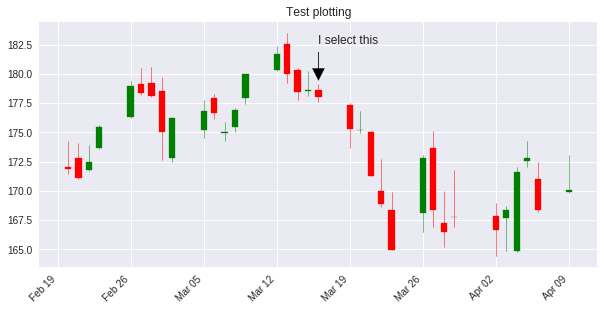

In [65]:
plot_pattern(stocks[0],'Test plotting','I select this',20)

In [34]:
print("look forward 5 days: (up,down)",lookforward(stocks[0],20,5) )

look forward 5 days: (up,down) (1, 4)


In [37]:
print("look backwards 5 days: (up,down)",lookbackward(stocks[0],20,5) )

look backwards 5 days: (up,down) (3, 2)


In [38]:
lookbackward(stocks[0],20,5)[0]

3

## Patterns 

### Pattern 1 : Black/White Hammer and Black/White shooting star

#### Black/White Hammer

In [0]:
def WhiteHammer(data,code,threshold,display = False):
  # (open-low)/(close-low) >= threshold and (high-close) < (close-open) 
  # Down -> Up
  appear = []
  correct = []
  l = data.shape[0]
  for i in range(l):
    day = data.iloc[i]
    
    open = day.open
    high = day.high
    low = day.low
    close= day.close
    
    if(close-low != 0):
      if( (open-low)/(close-low) >= threshold and (high-close) < (close-open) ):
        if(lookbackward(data,i,15)[1] >= 8):
          appear.append(i)
          if(lookforward(data,i,15)[0] >= 8):
            correct.append(i)
            if(display):
              plot_pattern(data,'White Hammer of '+ code+' with threshold = '+str(threshold),'Hammer day',i)         
              
              
  acc = len(correct)/len(appear) if len(correct) != 0 else 0
  return appear,correct,acc

##### Test

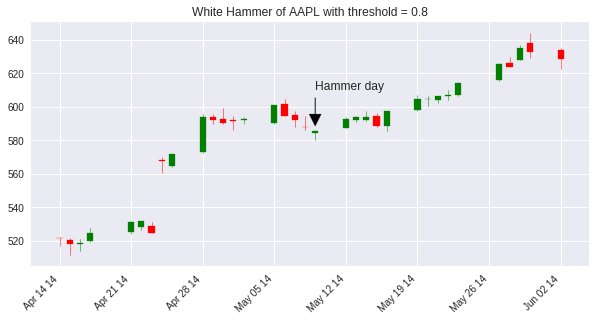

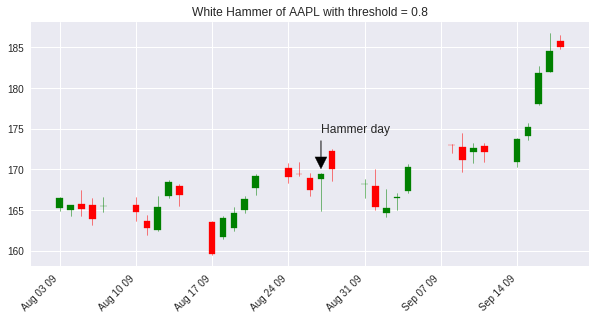

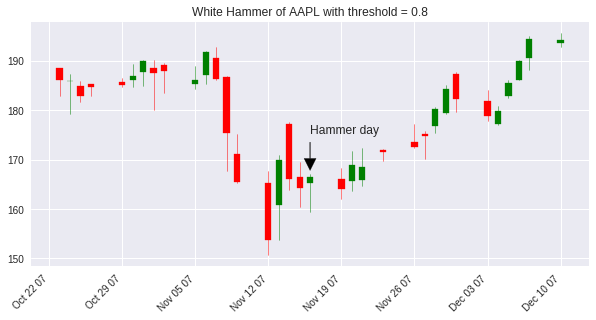

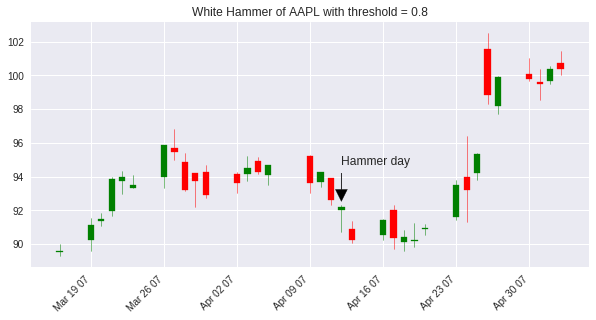

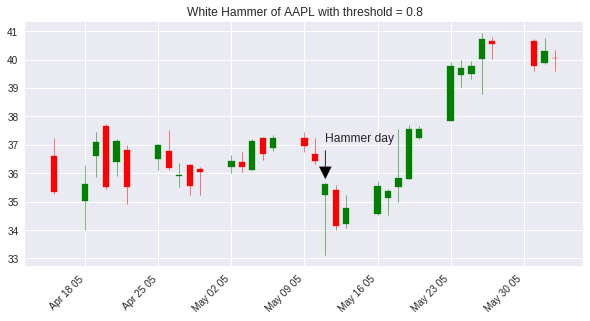

acc :  0.29411764705882354


In [99]:
appear,correct,acc = WhiteHammer(stocks[0],'AAPL',0.8,display=True)
print('acc : ',acc)

In [0]:
def BlackHammer(data,code,threshold,display = False):
  # Down -> Up
  appear = []
  correct = []
  l = data.shape[0]
  for i in range(l):
    day = data.iloc[i]
    
    open = day.open
    high = day.high
    low = day.low
    close= day.close
    
    if not open-low == 0:
      if((close-low)/(open-low) >= threshold and (high-open) < (open-close) ):
        if(lookbackward(data,i,15)[1] >= 8):
          appear.append(i)
          if(lookforward(data,i,15)[0] >= 8):
            correct.append(i)
            if(display):
              plot_pattern(data,'Black Hammer of '+ code+' with threshold = '+str(threshold),'BlackHammer',i)         
  acc = len(correct)/len(appear) if len(correct) != 0 else 0
  return appear,correct,acc

##### Test

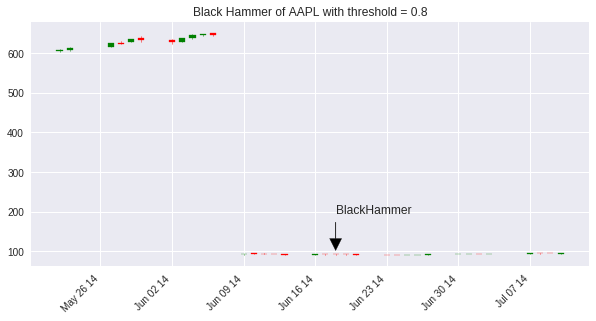

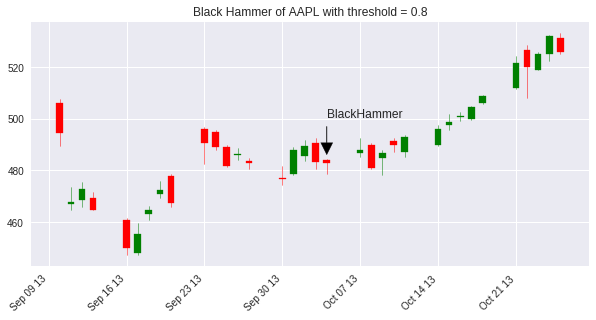

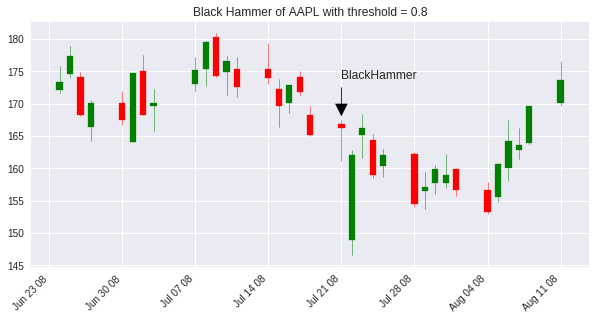

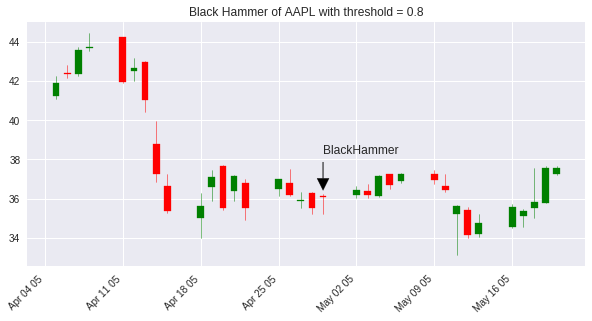

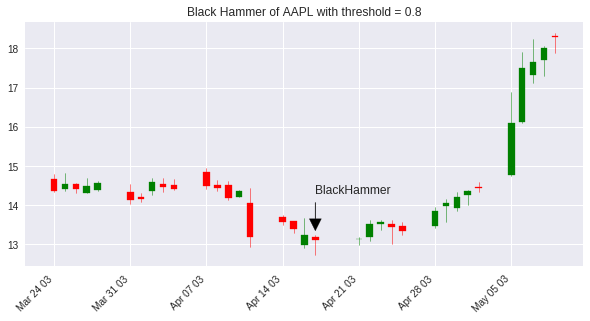

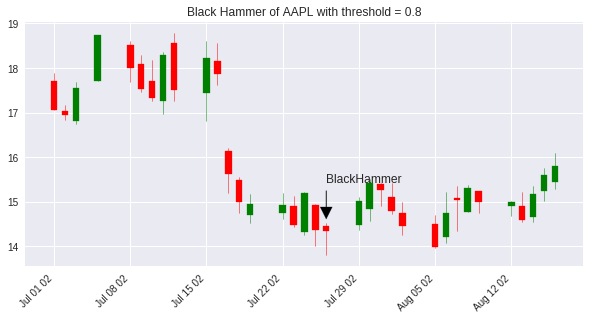

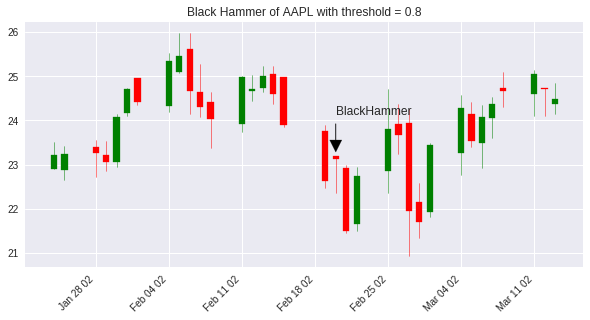

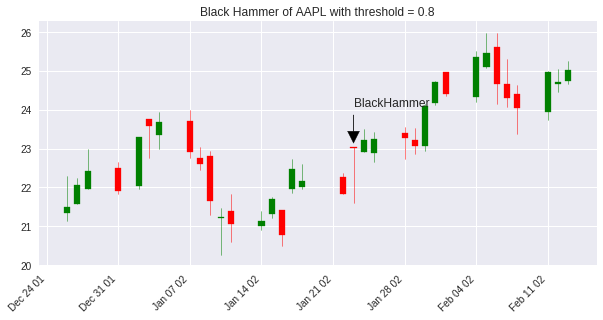

acc :  0.5


In [109]:
appear,correct,acc = BlackHammer(stocks[0],'AAPL',0.8,display=True)
print('acc : ',acc)

Plot lạ ngày đầu tiên : [link](https://www.washingtonpost.com/news/the-switch/wp/2014/06/09/apples-stock-price-just-dropped-more-than-500-a-share-but-dont-panic/)

#### Black/White shooting star

In [0]:
def BlackSS(data,code,threshold,display=False):
  # Up -> Down
  appear = []
  correct = []
  l = data.shape[0]
  for i in range(l):
    day = data.iloc[i]
    
    open = day.open
    high = day.high
    low = day.low
    close= day.close
    
    if not high-close == 0:
      if( (high-open)/(high-close) >= threshold and (close-low) < (open-close)):
        if(lookbackward(data,i,15)[0] >= 8):
          appear.append(i)
          if(lookforward(data,i,15)[1] >= 8):
            correct.append(i)
            if(display):
              plot_pattern(data,'Black Shooting star of '+ code+' with threshold = '+str(threshold),'BSS',i)         
  
  acc = len(correct)/len(appear) if len(correct) != 0 else 0
  return appear,correct,acc

##### Test

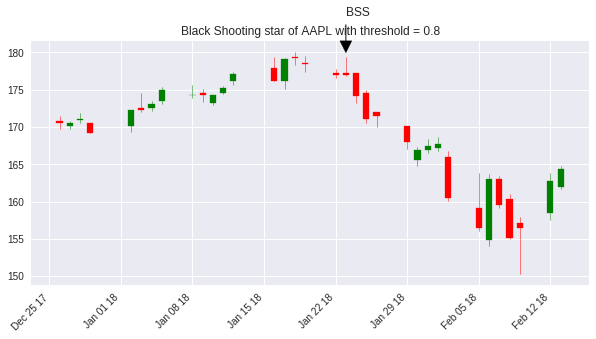

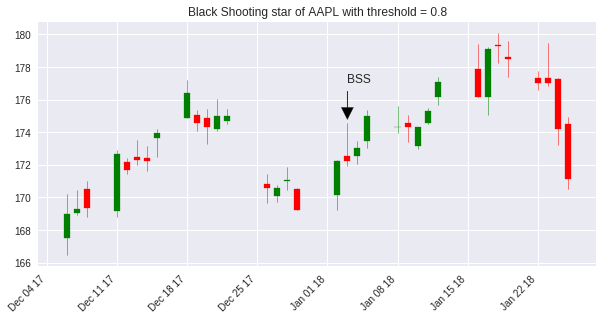

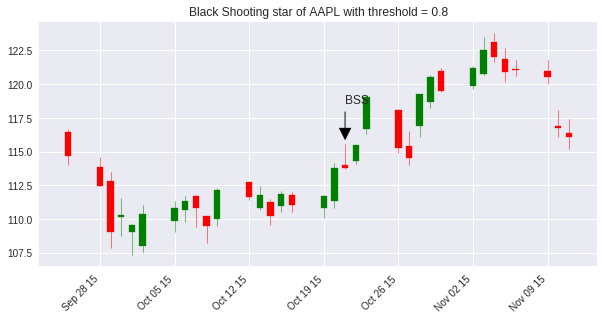

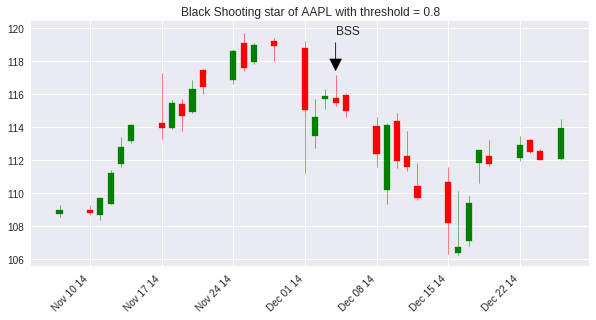

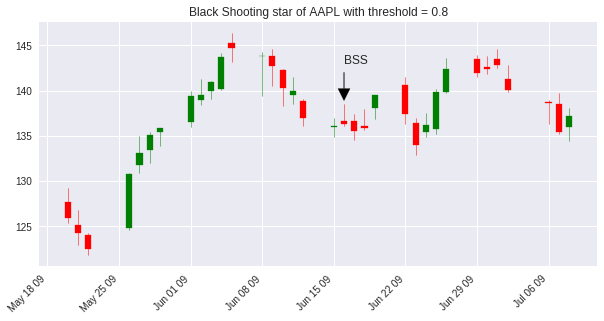

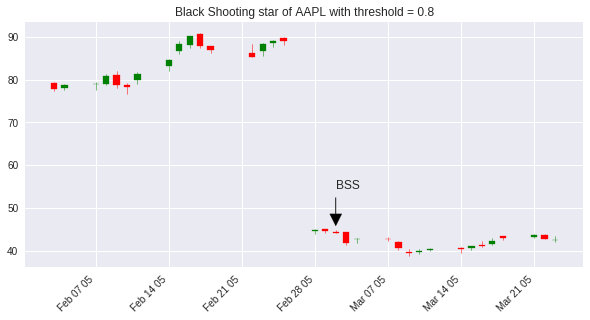

accuracy : 0.5454545454545454


In [102]:
a,c,acc = BlackSS(stocks[0],'AAPL',0.8,display=True)
print('accuracy :',acc)

In [0]:
def WhiteSS(data,code,threshold,display=False):
  # Up -> Down
  appear = []
  correct = []
  l = data.shape[0]
  for i in range(l):
    day = data.iloc[i]
    
    open = day.open
    high = day.high
    low = day.low
    close= day.close
    
    if not high-open == 0:
      if( (high-close)/(high-open) >= threshold and (open-low) < (close-open)):
        if(lookbackward(data,i,15)[0] >= 8):
          appear.append(i)
          if(lookforward(data,i,15)[1] >= 8):
            correct.append(i)
            if(display):
              plot_pattern(data,'White Shooting star of '+ code+' with threshold = '+str(threshold),'WSS',i)         
   
  acc = len(correct)/len(appear) if len(correct) != 0 else 0
  return appear,correct,acc
  

##### Test

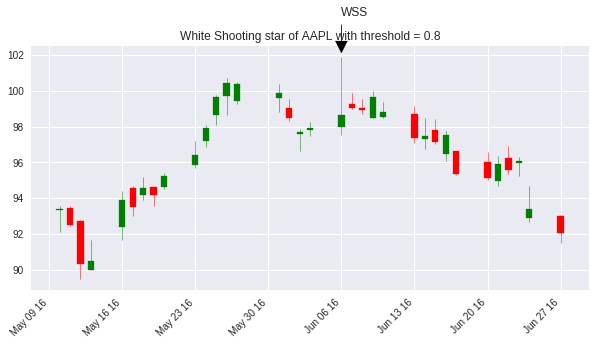

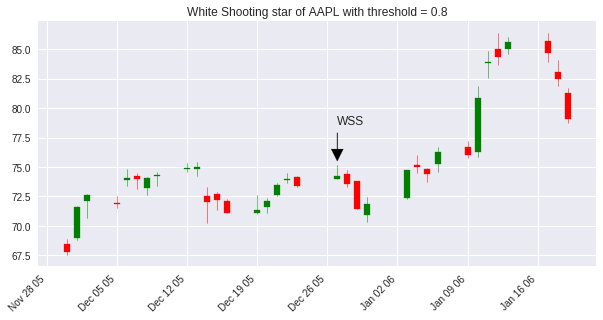

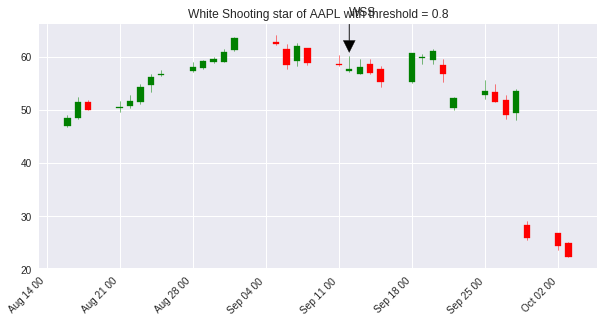

accuracy : 0.15789473684210525


In [105]:
a,c,acc = WhiteSS(stocks[0],'AAPL',0.8,display=True)
print('accuracy :',acc)

#### Calculate Accuracy pattern 1

In [0]:
list_threshold = [0.9,0.8,0.75,0.66,0.5]

In [0]:
result = []
for i in range(len(stocks)):
  for t in list_threshold:
    a,c,acc = WhiteHammer(stocks[i],stock_code[i],t,display=False)
    result.append({'Pattern':'WH','code': stock_code[i],'threshold':t,'appear':len(a),'correct':len(c),'acc' : acc})
    a,c,acc = BlackHammer(stocks[i],stock_code[i],t,display=False)
    result.append({'Pattern':'BH','code': stock_code[i],'threshold':t,'appear':len(a),'correct':len(c),'acc' : acc})
    a,c,acc = BlackSS(stocks[i],stock_code[i],t,display=False)
    result.append({'Pattern':'BSS','code': stock_code[i],'threshold':t,'appear':len(a),'correct':len(c),'acc' : acc})
    a,c,acc = WhiteSS(stocks[i],stock_code[i],t,display=False)
    result.append({'Pattern':'WSS','code': stock_code[i],'threshold':t,'appear':len(a),'correct':len(c),'acc' : acc})

In [0]:
acc_p1 = pd.DataFrame(result)
acc_p1 = acc_p1[['code','Pattern','threshold','appear','correct','acc']]

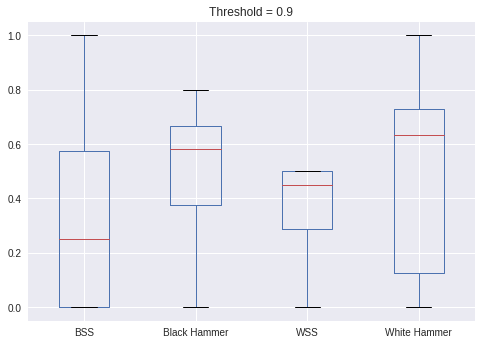

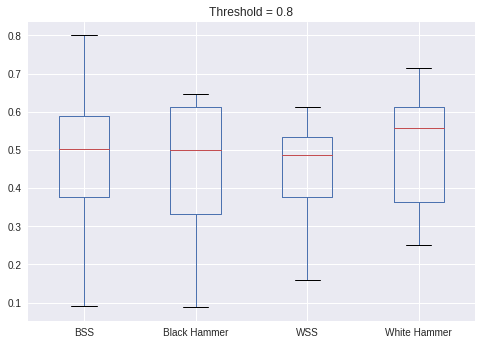

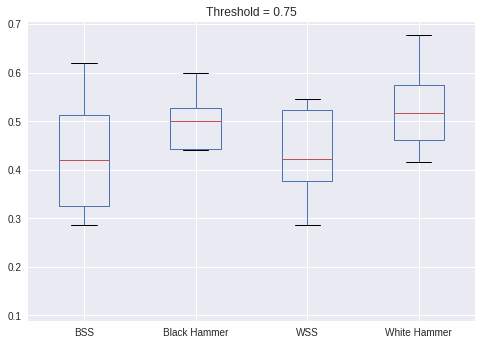

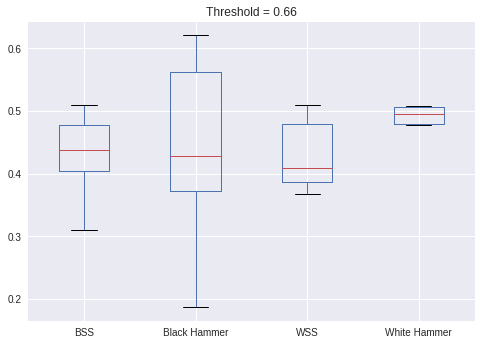

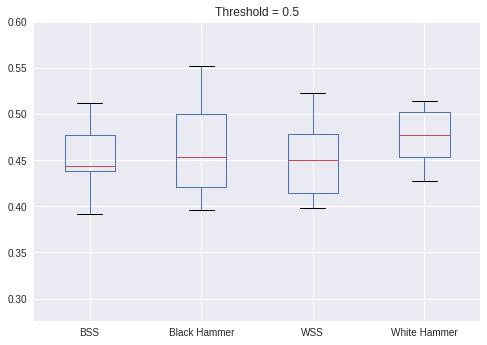

In [141]:
for t in list_threshold:

  acc_08 = acc_p1[acc_p1.threshold == t]
  WH = list(acc_08[acc_08.Pattern == 'WH'].acc)
  BH = list(acc_08[acc_08.Pattern =='BH'].acc)
  BS = list(acc_08[acc_08.Pattern == 'BSS'].acc)
  WS = list(acc_08[acc_08.Pattern == 'WSS'].acc)

  df_plot = pd.DataFrame({
      'White Hammer' : WH,
      'Black Hammer' : BH,
      'WSS' : WS,
      'BSS' : BS
  })
  df_plot.plot.box(title='Threshold = '+str(t))

In [0]:
acc_p1.to_csv('P1.csv')
files.download('P1.csv')

Text(0.5,1,'Accuracy of pattern 1s')

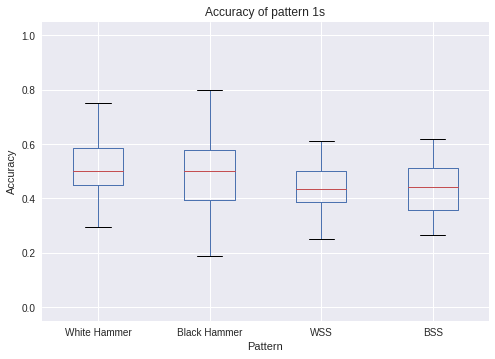

In [193]:
WH = list(acc_p1[acc_p1.Pattern == 'WH'].acc)
BH = list(acc_p1[acc_p1.Pattern =='BH'].acc)
BS = list(acc_p1[acc_p1.Pattern == 'BSS'].acc)
WS = list(acc_p1[acc_p1.Pattern == 'WSS'].acc)

df_plot = pd.DataFrame({
    'White Hammer' : WH,
    'Black Hammer' : BH,
    'WSS' : WS,
    'BSS' : BS
})
df_plot = df_plot[['White Hammer','Black Hammer','WSS','BSS']]
ax = df_plot.plot.box()
ax.set_xlabel('Pattern')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of pattern 1s')

### Pattern 2 : Piercing & Dark Cloud Cover

#### Dark Cloud Cover : 

In [0]:
def DarkCloudCover(data,code,threshold,display = False):
  # Correct : ngày hôm qua 
  appear = []
  correct = []
  l = data.shape[0]
  for i in range(1,l):
    day1 = data.iloc[[i-1]] # ngày mới hơn là ngày giảm
    day2 = data.iloc[[i]] # ngày hôm qua là ngày tăng
    
    M = day1.open[0] - day1.close[0]
    N = day2.close[0] - day2.open[0]
    
    if N >0 and M>0 and M/N > threshold :
      # check if >8/15 days before day 2 is up
      if(lookbackward(data,i,15)[0] >=8 ):
        appear.append(i)
        if(lookforward(data,i-1,15)[1] >=8):
          correct.append(i)
          if(display):
            plot_pattern(data,'Dark cloud cover of '+ code, 'DCC',i)
  
  acc = len(correct)/len(appear) if len(appear) != 0 else 0
  return appear,correct,acc

##### test

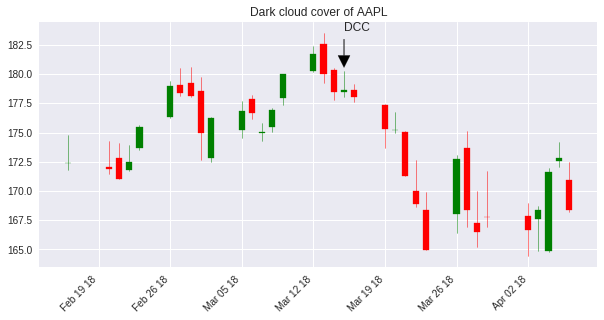

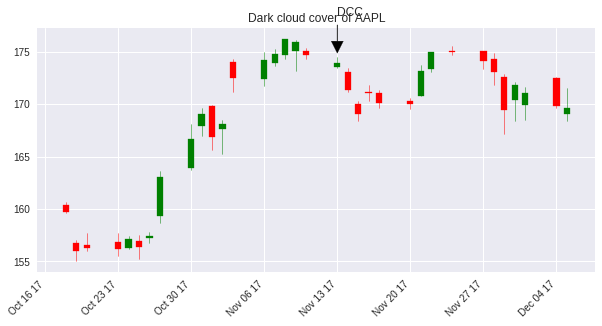

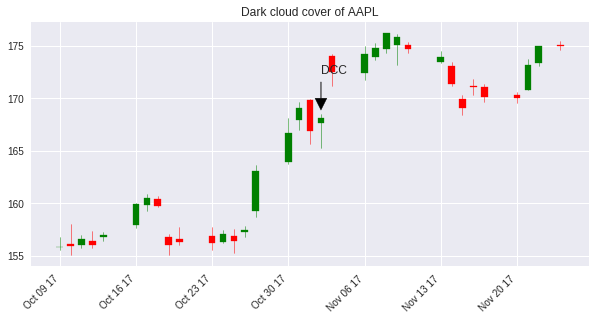

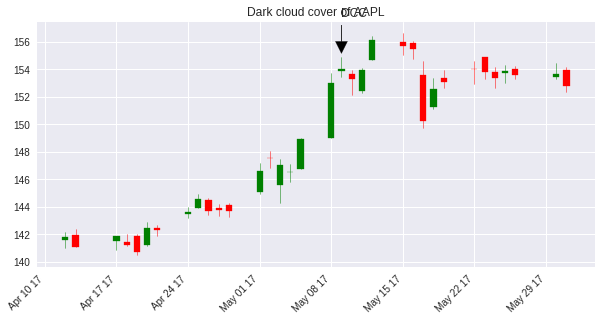

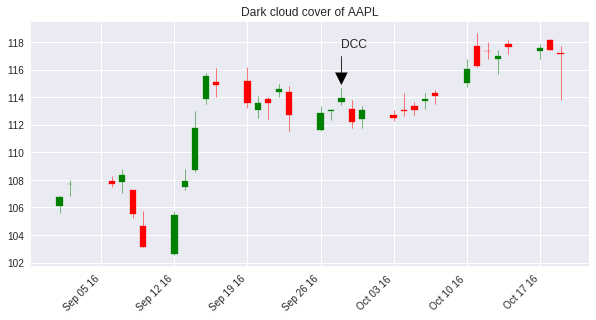

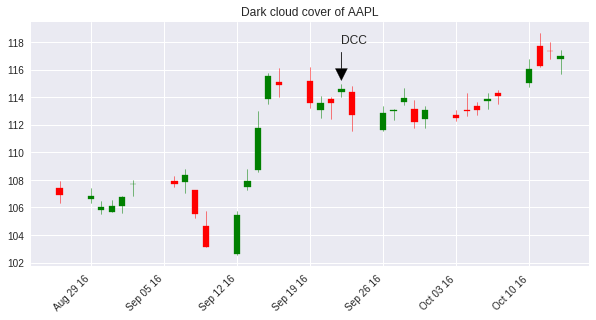

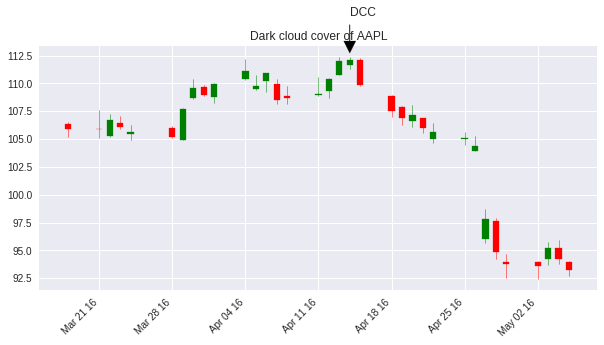

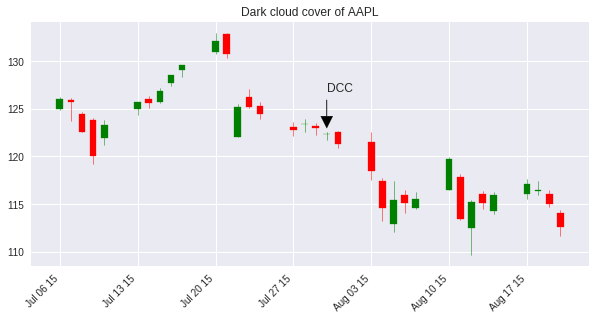

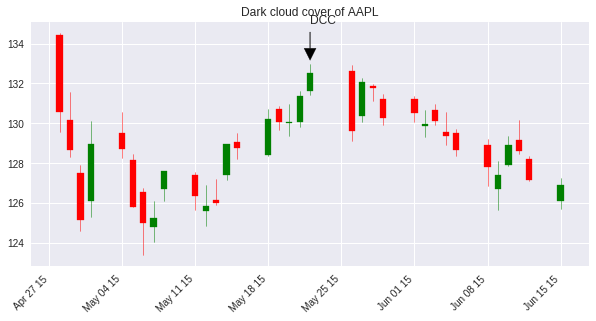

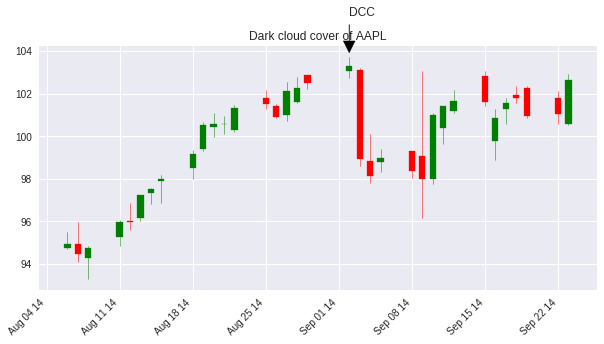

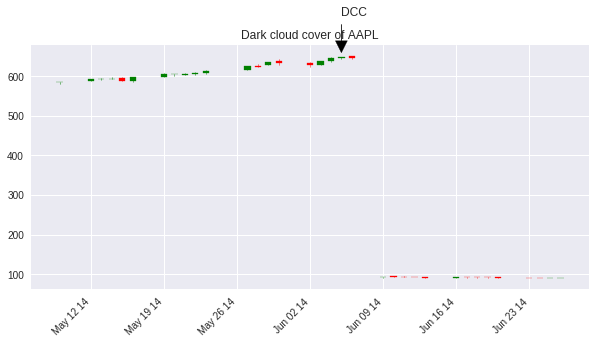

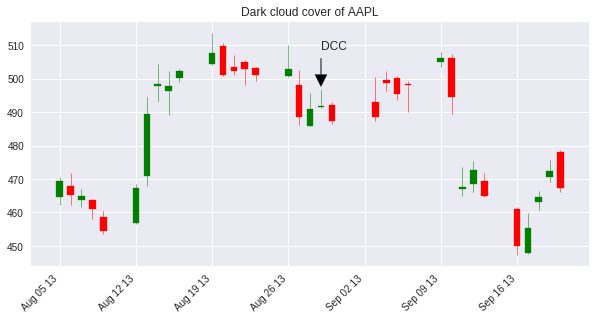

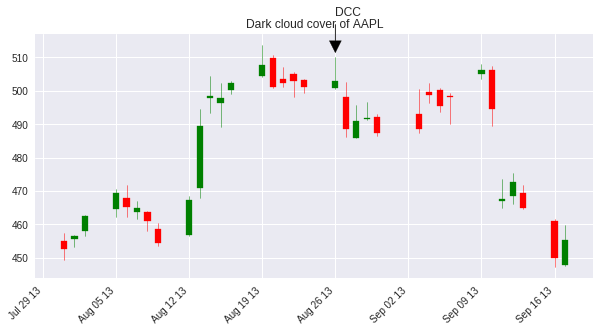

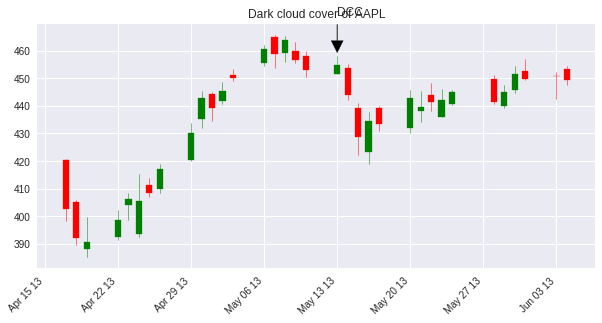

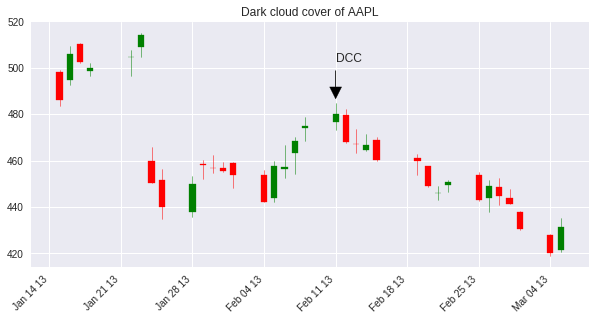

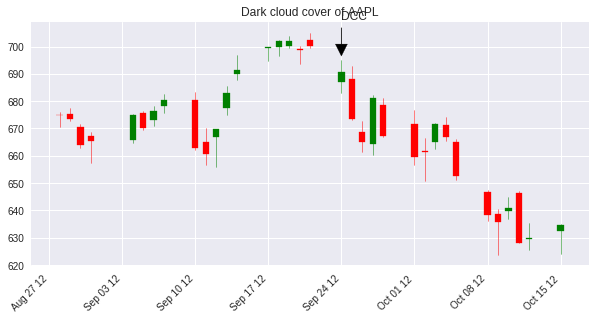

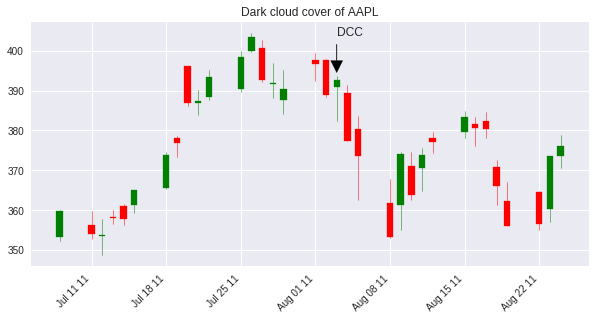

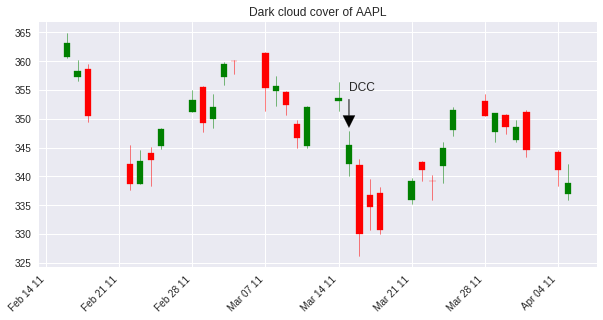

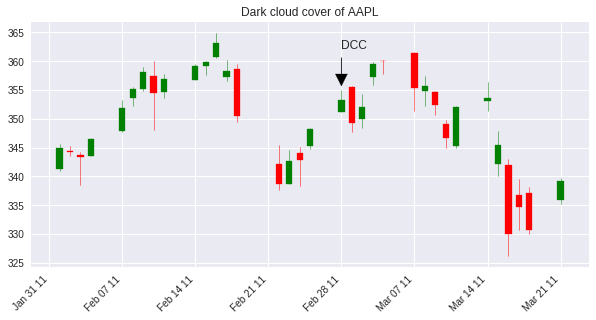

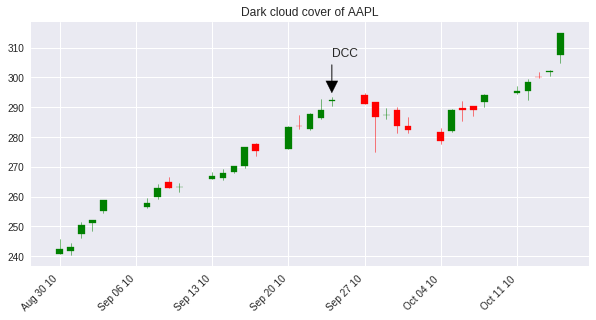

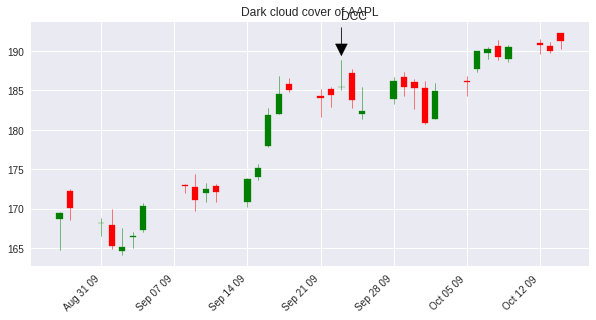

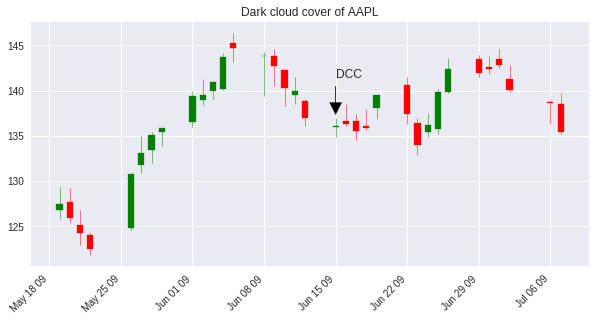

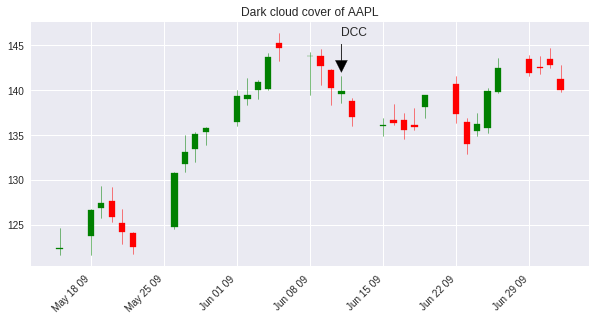

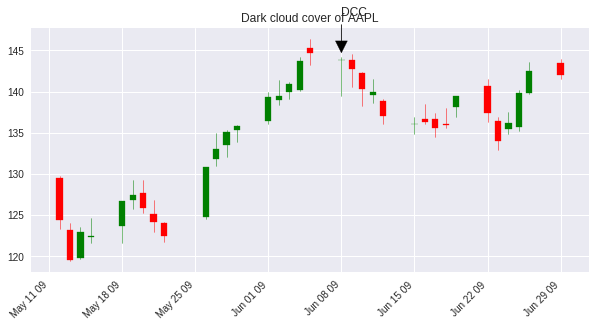

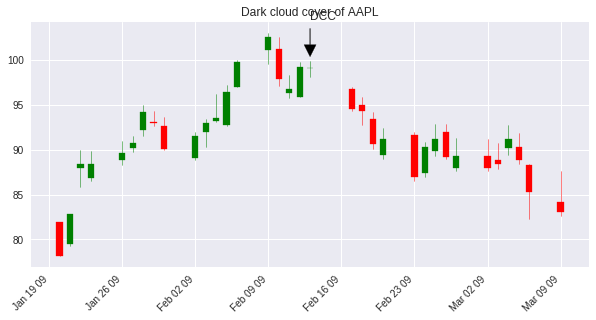

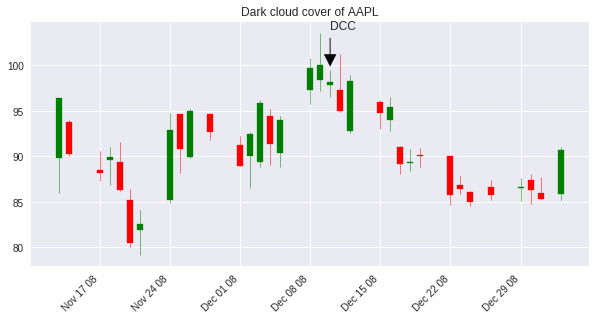

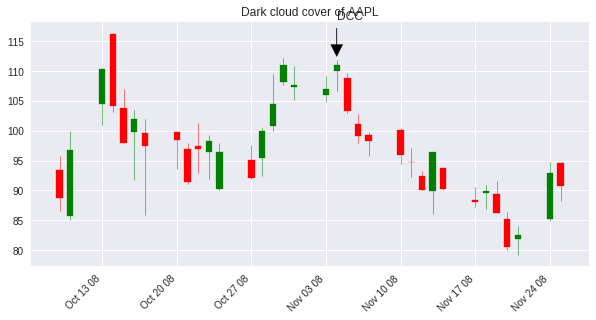

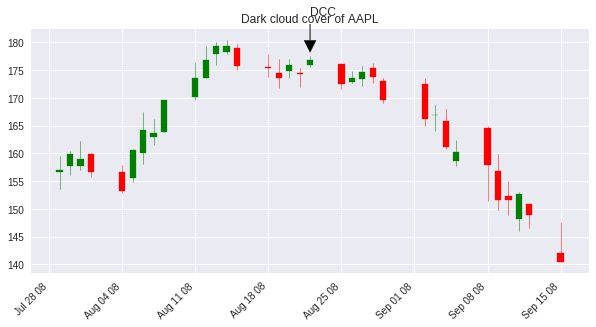

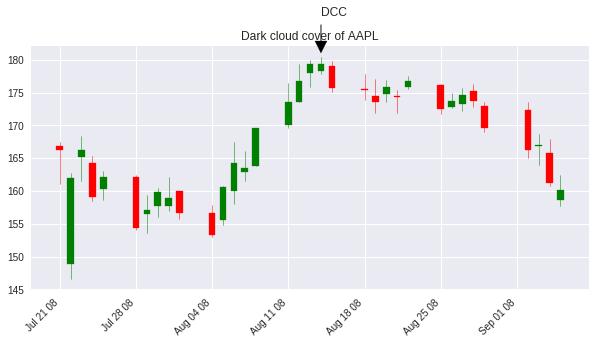

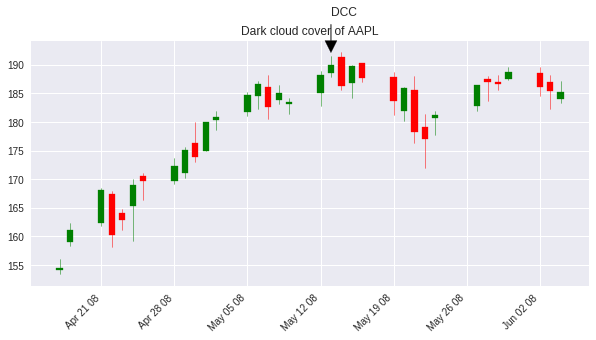

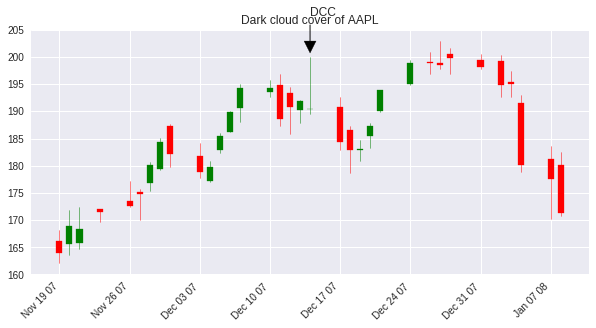

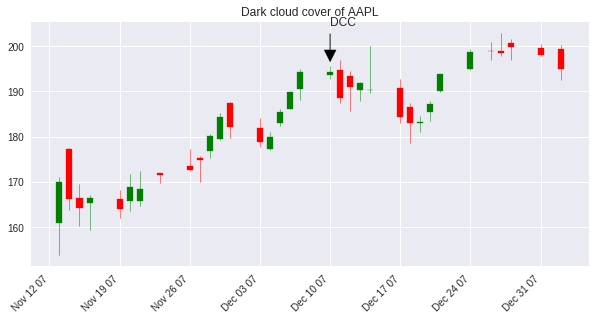

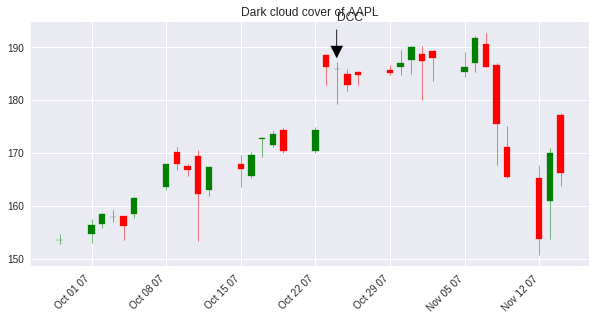

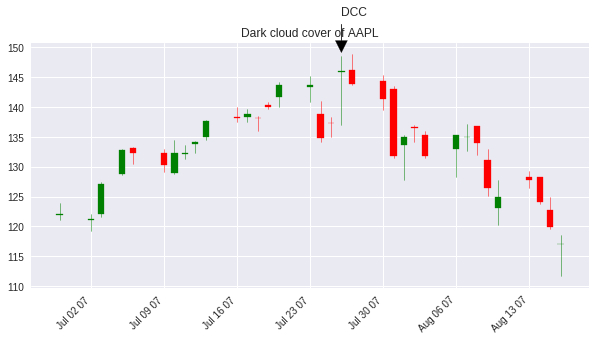

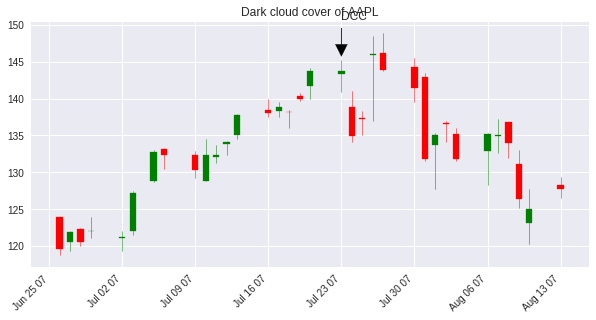

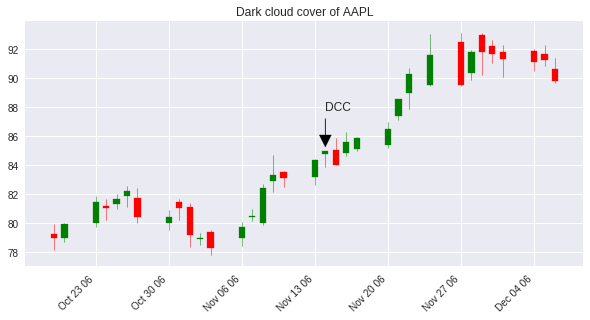

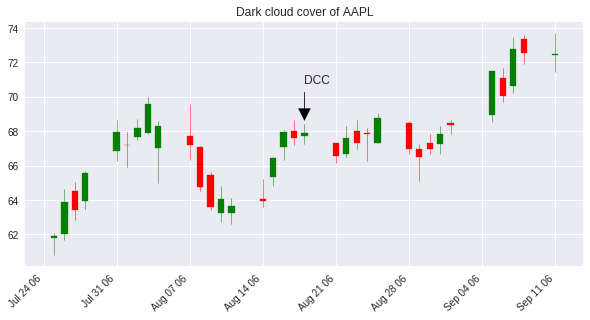

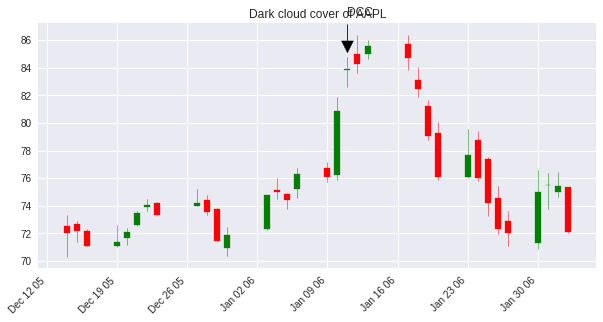

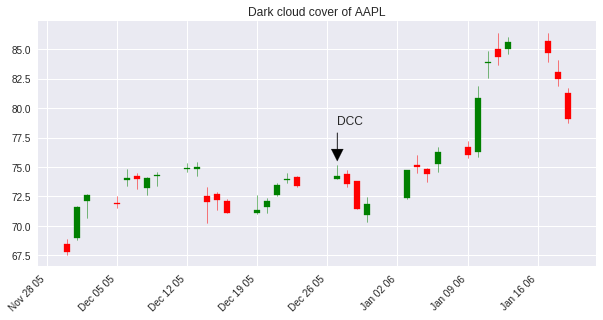

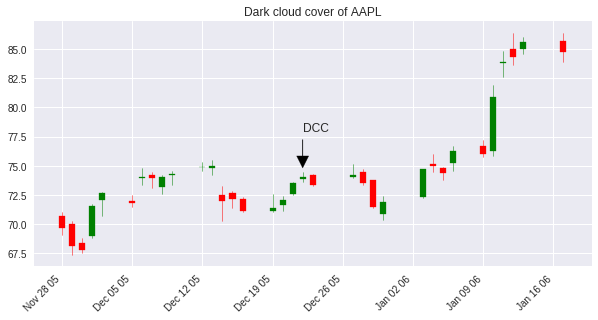

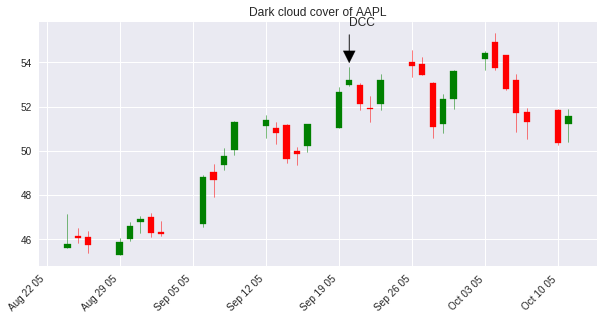

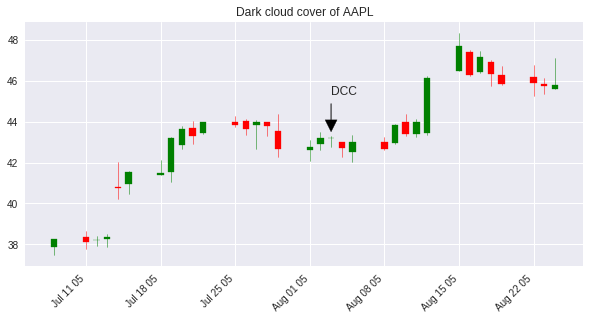

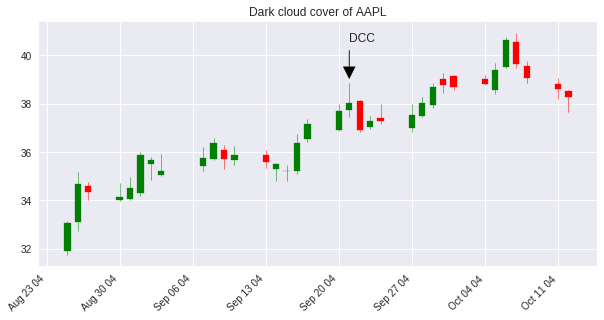

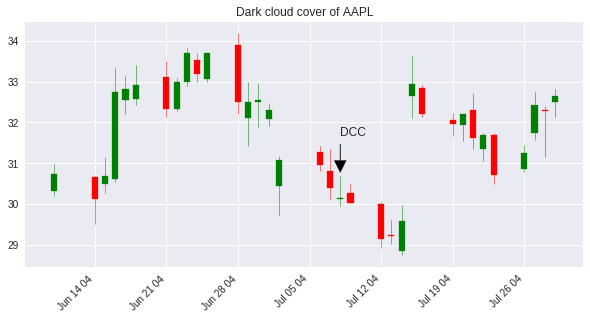

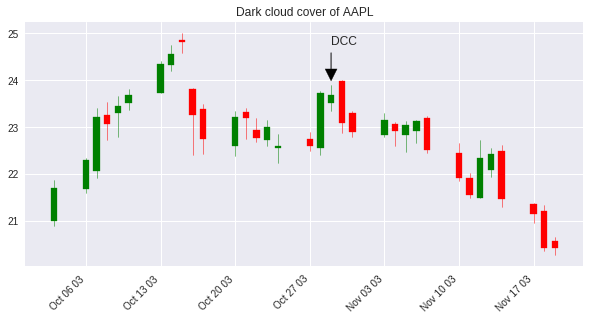

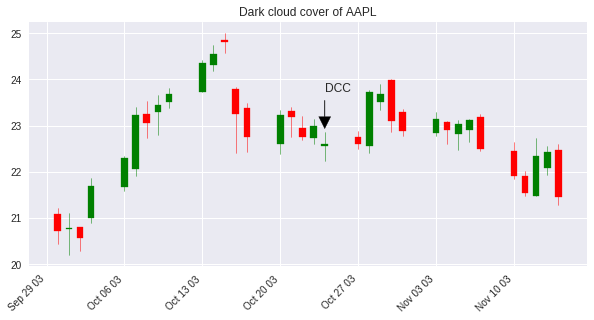

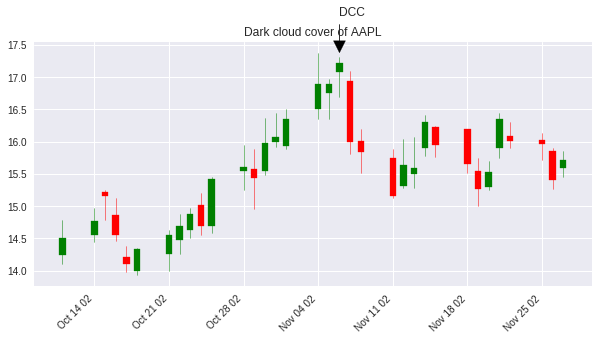

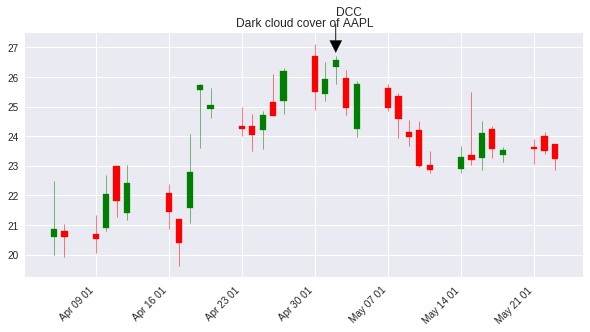

([21,
  73,
  104,
  111,
  181,
  235,
  358,
  388,
  392,
  403,
  405,
  462,
  464,
  504,
  518,
  541,
  552,
  649,
  655,
  660,
  669,
  682,
  729,
  908,
  911,
  972,
  1062,
  1117,
  1123,
  1164,
  1167,
  1240,
  1303,
  1397,
  1539,
  1541,
  1551,
  1666,
  1685,
  1783,
  1794,
  1800,
  1843,
  1851,
  1867,
  1870,
  1878,
  1898,
  1901,
  1925,
  1927,
  2012,
  2033,
  2154,
  2186,
  2224,
  2226,
  2229,
  2268,
  2307,
  2351,
  2376,
  2427,
  2433,
  2498,
  2562,
  2600,
  2604,
  2636,
  2651,
  2699,
  2702,
  2730,
  2872,
  2933,
  3085,
  3095,
  3097,
  3104,
  3163,
  3196,
  3224,
  3238,
  3415,
  3467,
  3501,
  3504,
  3530,
  3535,
  3564,
  3567,
  3639,
  3642,
  3823,
  3885,
  4093,
  4114,
  4136,
  4264,
  4302,
  4309,
  4321,
  4572,
  4582],
 [21,
  104,
  111,
  235,
  388,
  392,
  504,
  682,
  729,
  911,
  972,
  1164,
  1167,
  1240,
  1303,
  1397,
  1685,
  1783,
  1794,
  1901,
  2154,
  2224,
  2226,
  2229,
  2307,
  2351,

In [158]:
DarkCloudCover(stocks[0],'AAPL',3,display=True)

#### Piercing

In [0]:
def Piercing(data,code,threshold,display = False):
  # Correct : ngày hôm qua 
  appear = []
  correct = []
  l = data.shape[0]
  for i in range(1,l):
    day1 = data.iloc[[i-1]] # ngày mới hơn là ngày giảm
    day2 = data.iloc[[i]] # ngày hôm qua là ngày tăng
    
    M = day1.close[0] - day1.open[0]
    N = day2.open[0] - day2.close[0]
    
    if N >0 and M>0 and M/N > threshold :
      # check if >8/15 days before day 2 is up
      if(lookbackward(data,i,15)[1] >=8 ):
        appear.append(i)
        if(lookforward(data,i-1,15)[0] >=8):
          correct.append(i)
          if(display):
            plot_pattern(data,'Piercing of '+ code, 'Piercing',i)
  
  acc = len(correct)/len(appear) if len(appear) != 0 else 0
  return appear,correct,acc

##### Test

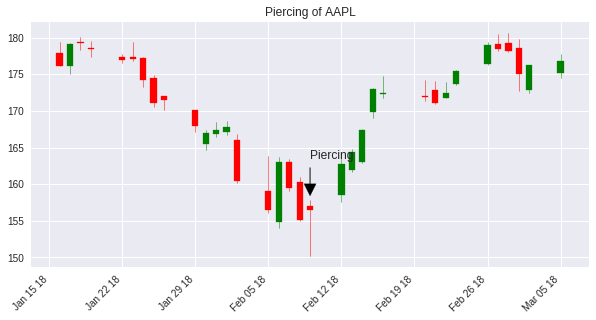

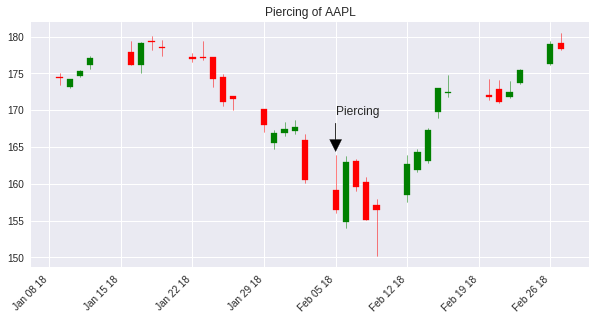

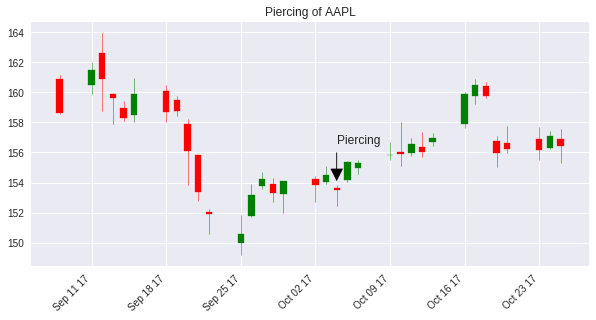

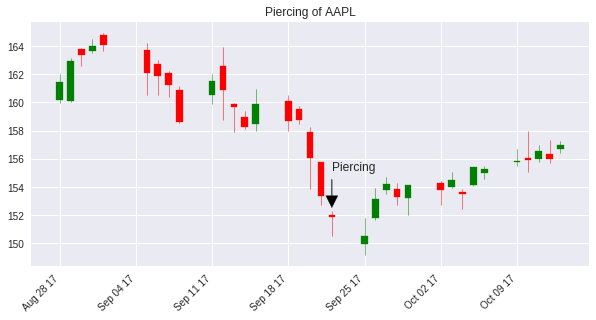

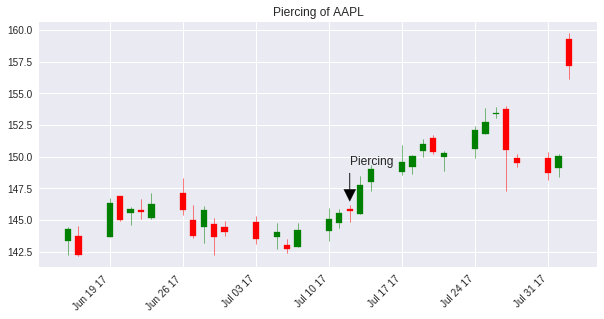

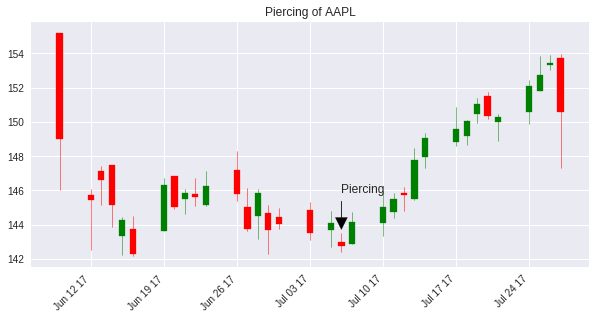

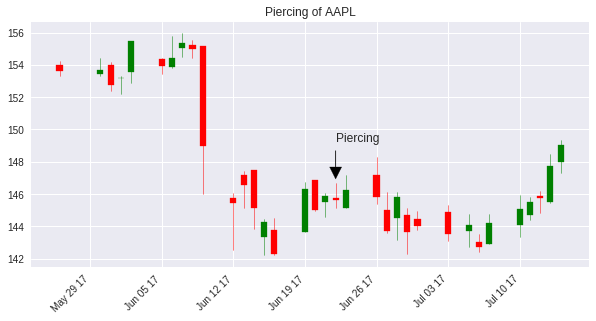

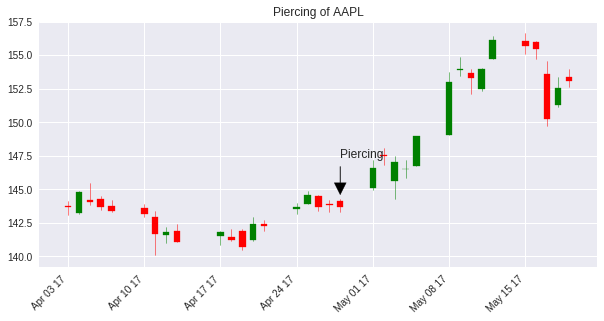

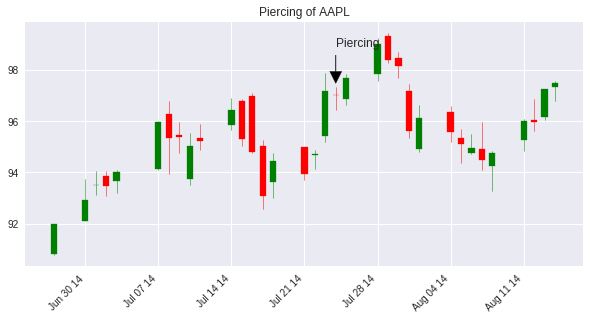

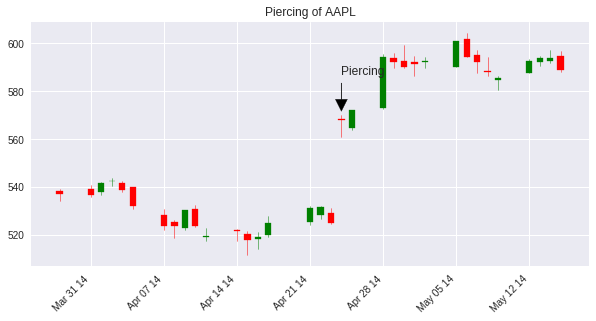

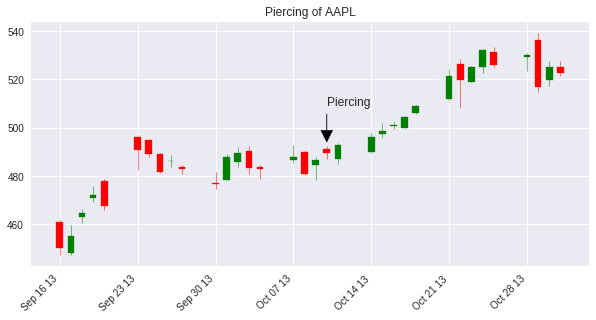

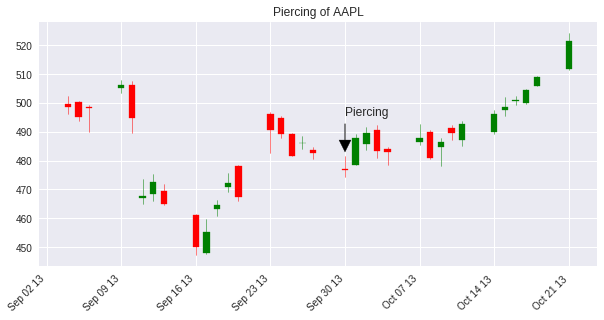

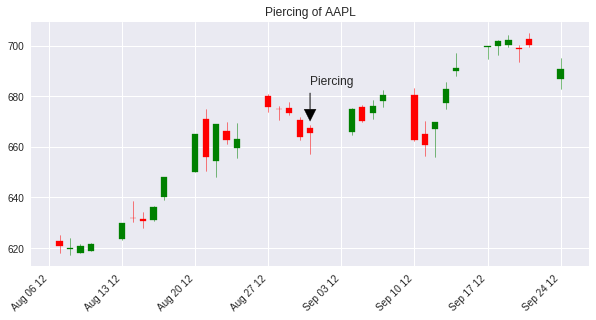

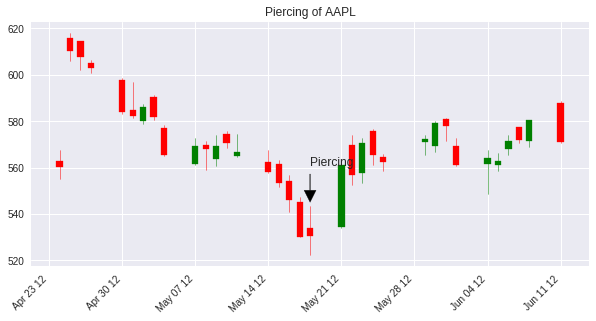

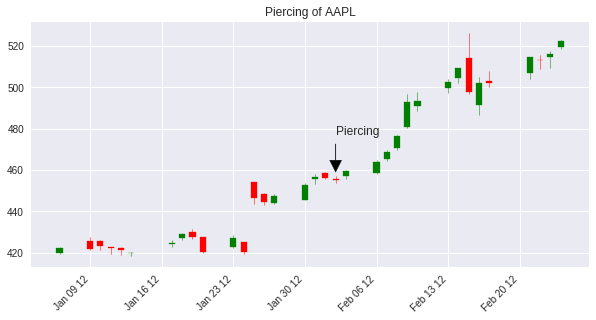

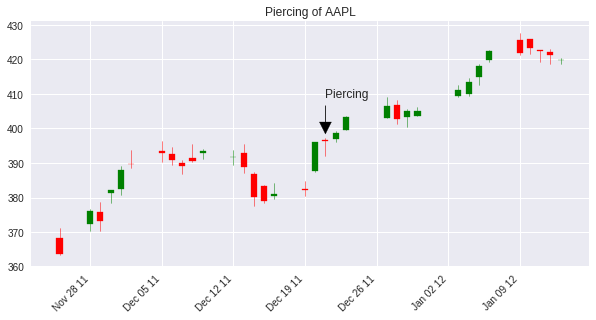

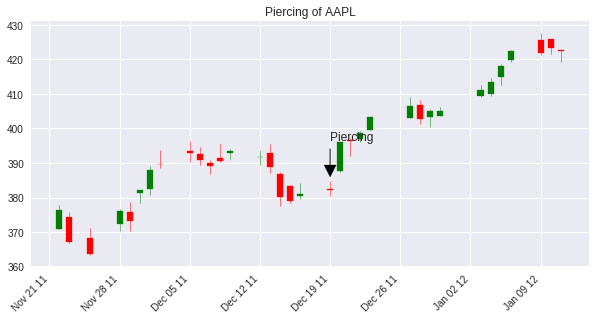

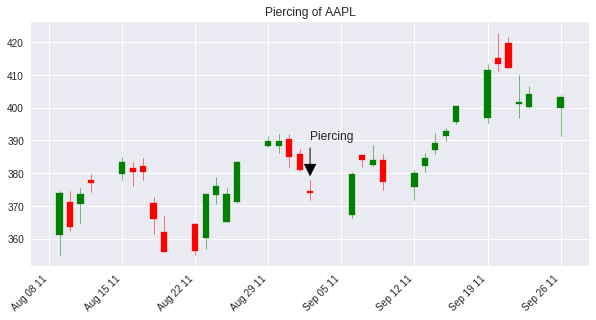

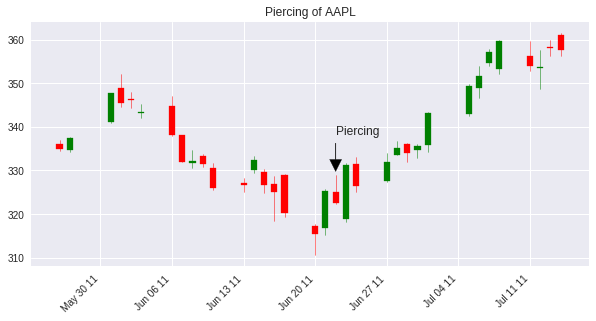

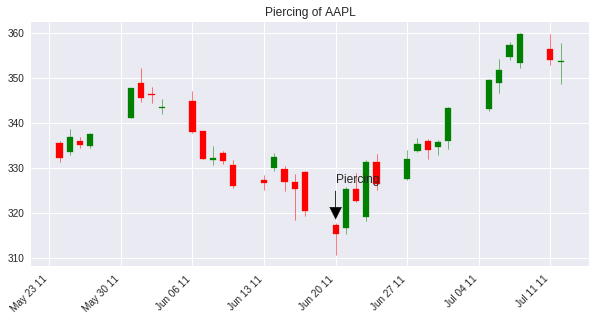

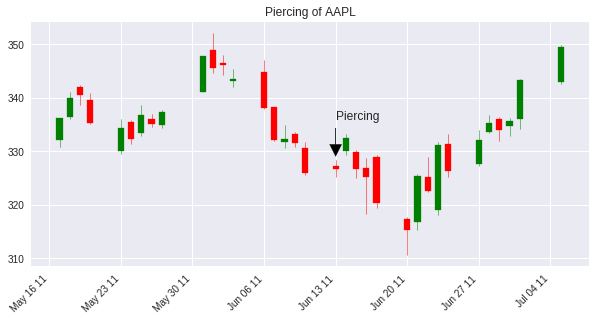

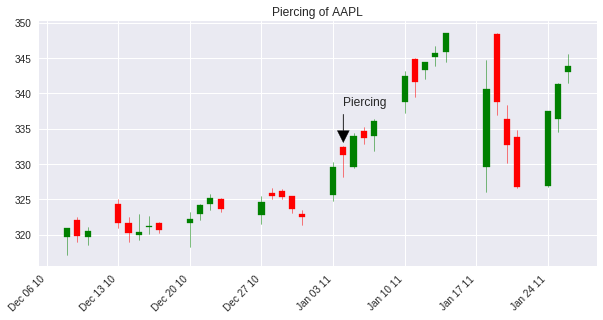

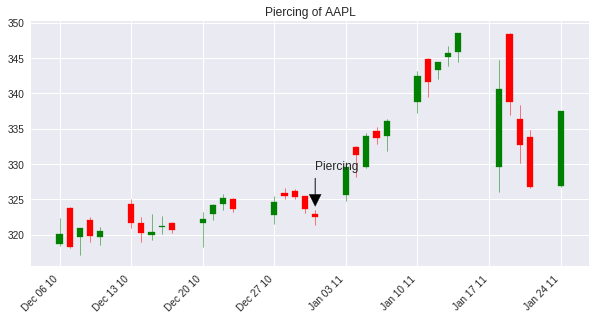

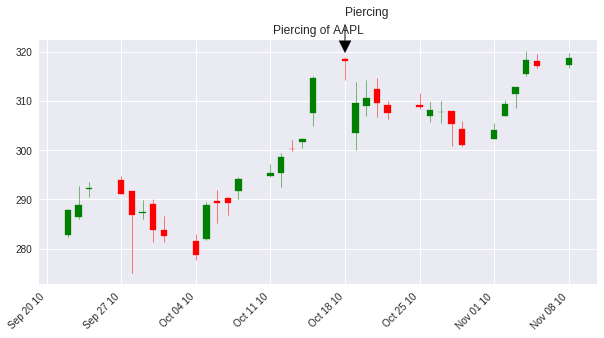

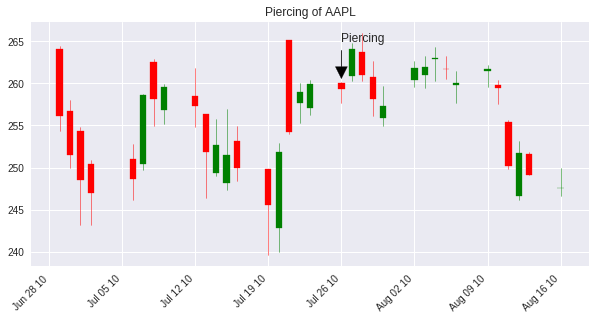

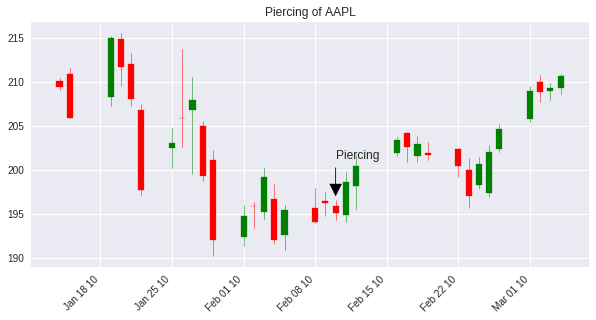

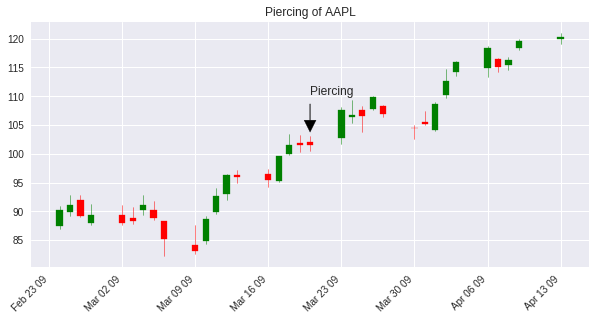

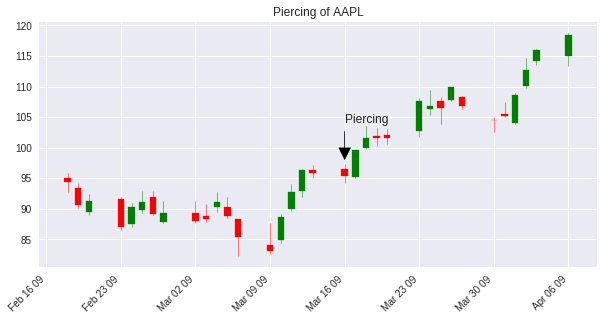

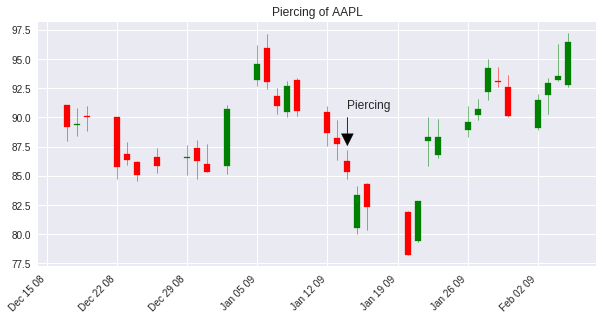

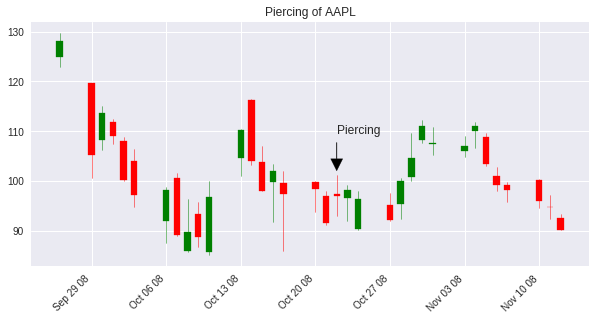

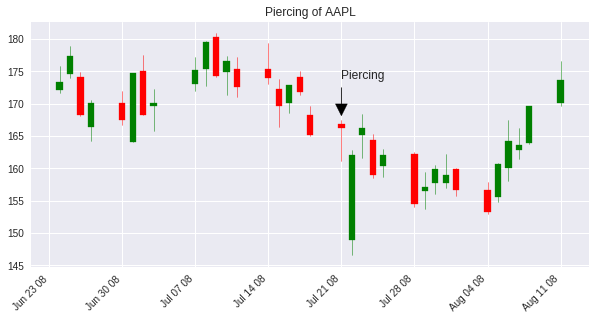

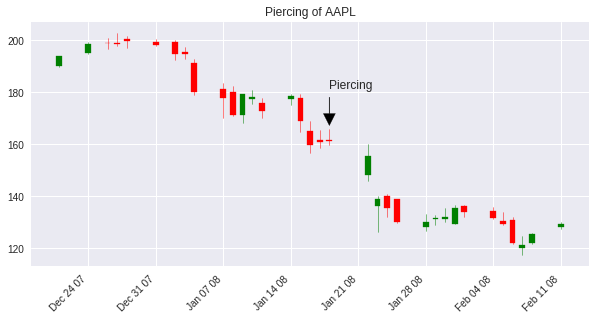

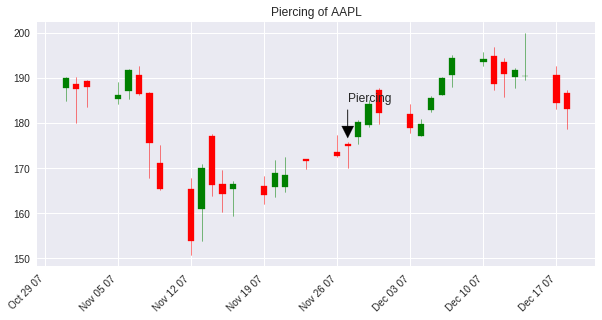

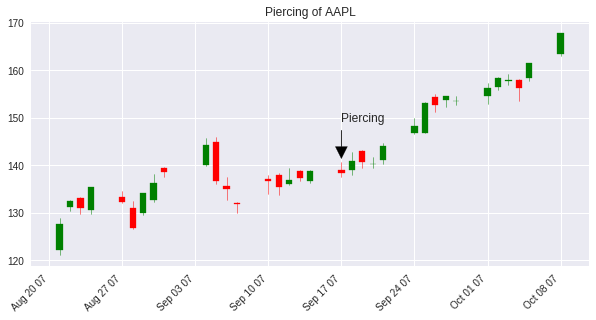

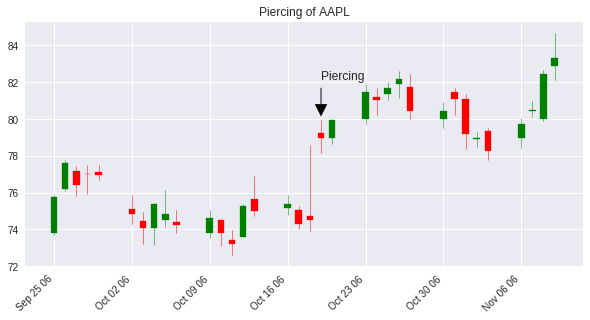

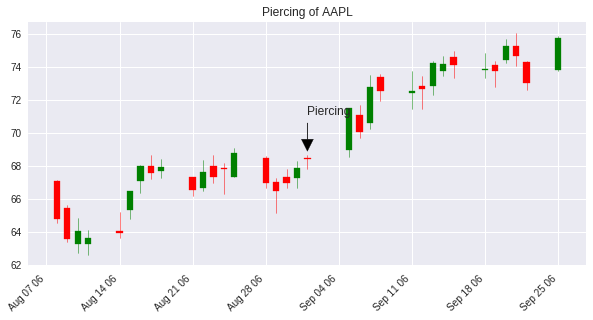

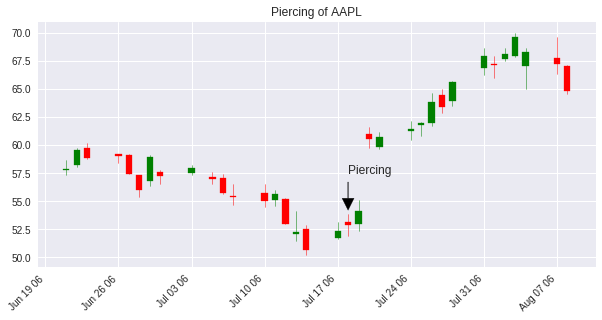

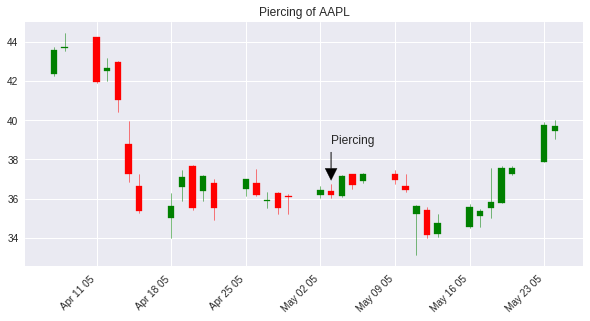

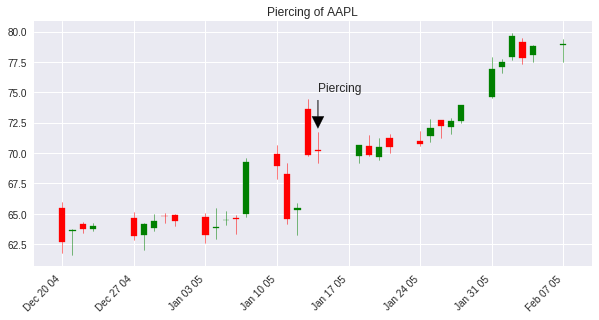

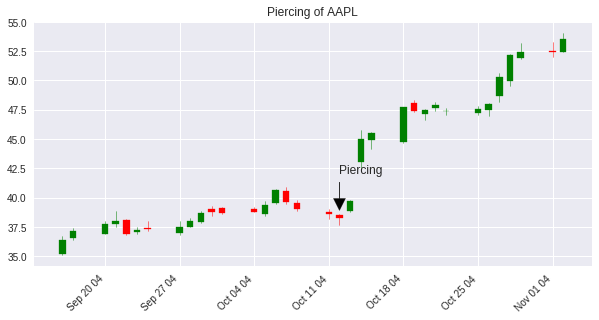

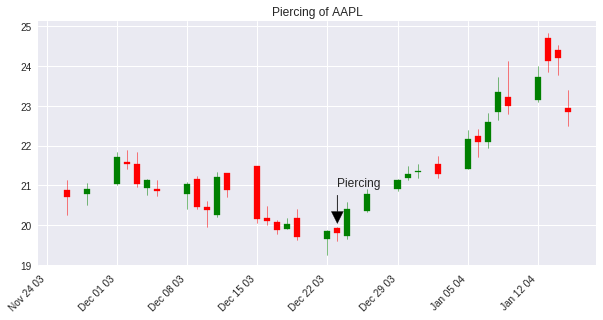

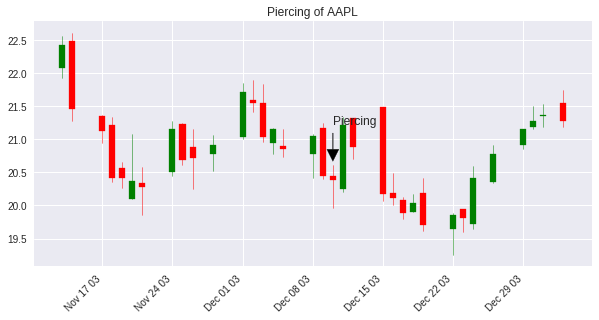

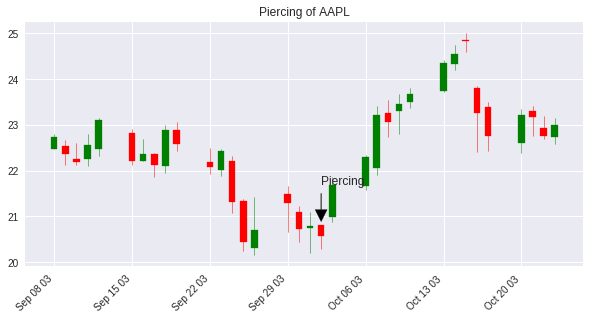

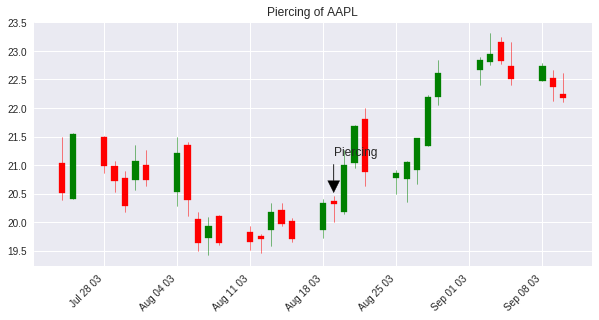

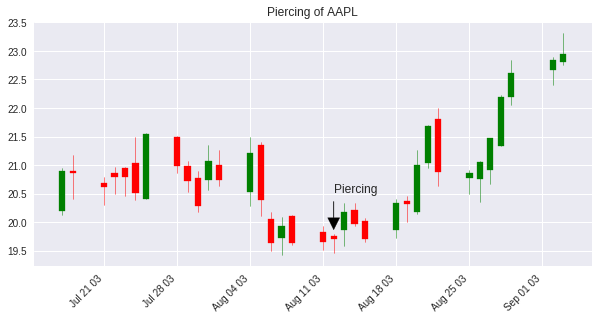

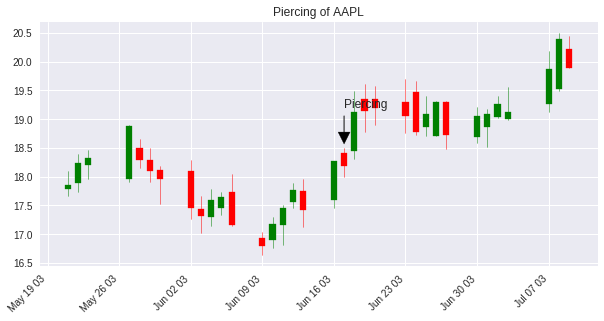

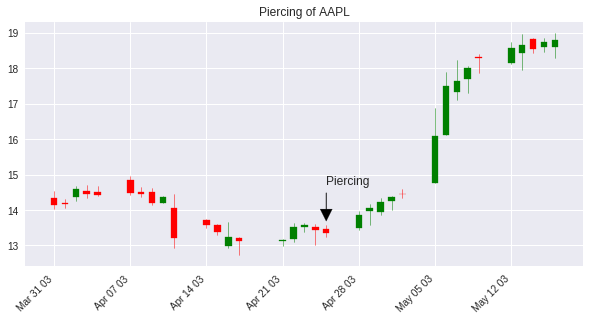

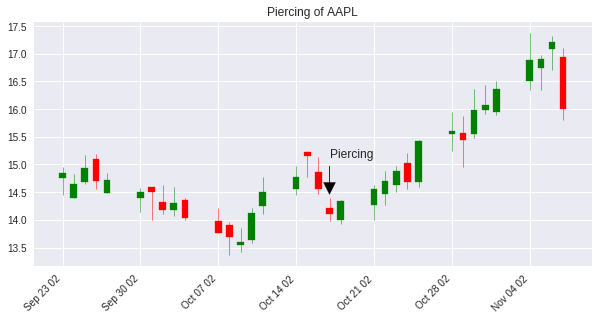

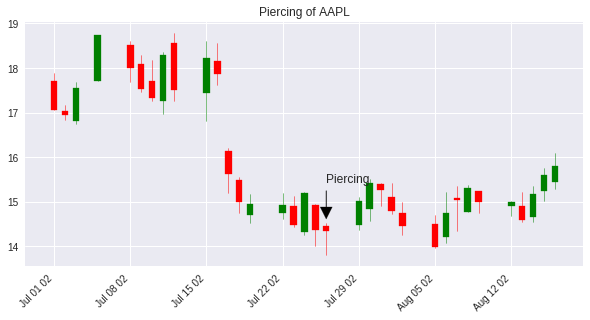

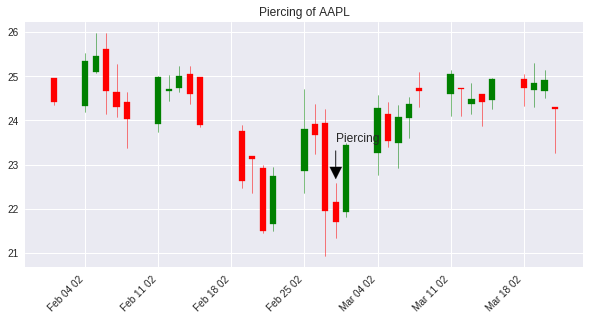

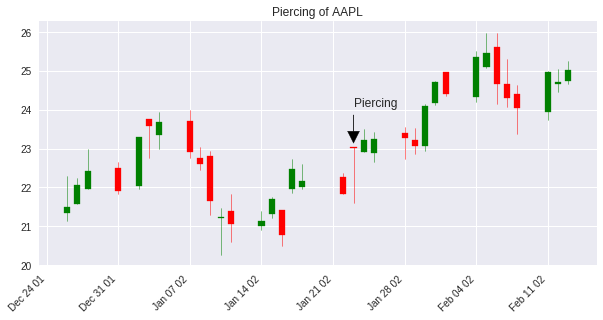

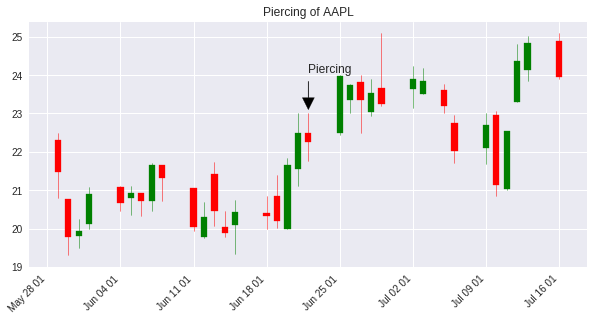

([44,
  48,
  86,
  132,
  140,
  191,
  195,
  204,
  240,
  242,
  260,
  378,
  381,
  562,
  581,
  734,
  736,
  831,
  938,
  949,
  1001,
  1012,
  1034,
  1135,
  1143,
  1159,
  1281,
  1301,
  1332,
  1412,
  1485,
  1493,
  1559,
  1587,
  1589,
  1608,
  1618,
  1663,
  1714,
  1716,
  1721,
  1777,
  1831,
  1833,
  1885,
  1944,
  1958,
  1987,
  2058,
  2064,
  2069,
  2283,
  2287,
  2292,
  2328,
  2337,
  2385,
  2412,
  2415,
  2451,
  2577,
  2613,
  2663,
  2682,
  2817,
  2837,
  2844,
  2890,
  2896,
  2899,
  2902,
  2917,
  2923,
  2956,
  2979,
  3033,
  3074,
  3174,
  3260,
  3279,
  3293,
  3334,
  3400,
  3453,
  3601,
  3610,
  3613,
  3622,
  3658,
  3689,
  3694,
  3733,
  3769,
  3849,
  3899,
  3949,
  3957,
  3974,
  3981,
  4029,
  4037,
  4052,
  4054,
  4060,
  4081,
  4085,
  4228,
  4240,
  4255,
  4353,
  4389,
  4402],
 [44,
  48,
  132,
  140,
  191,
  195,
  204,
  242,
  938,
  1001,
  1135,
  1143,
  1412,
  1485,
  1559,
  1587,
  1589,
 

In [168]:
Piercing(stocks[0],'AAPL',3,display=True)

#### Compare Accuracy

In [0]:
list_threshold = [0.5,0.75,1,2,3]
result = []

    

In [0]:
for i in range(len(stocks)):
  for t in list_threshold:
    a,c,acc = DarkCloudCover(stocks[i],stock_code[i],t,display=False)
    result.append({'Pattern':'DCC','code': stock_code[i],'threshold':t,'appear':len(a),'correct':len(c),'acc' : acc})
    a,c,acc = Piercing(stocks[i],stock_code[i],t,display=False)
    result.append({'Pattern':'PIER','code': stock_code[i],'threshold':t,'appear':len(a),'correct':len(c),'acc' : acc})

In [0]:
acc_p2 = pd.DataFrame(result)
acc_p2 = acc_p2[['code','Pattern','threshold','appear','correct','acc']]

In [0]:
acc_p2.to_csv('P2.csv')
files.download('P2.csv')

In [0]:
acc_p2

Text(0,0.5,'Accuracy')

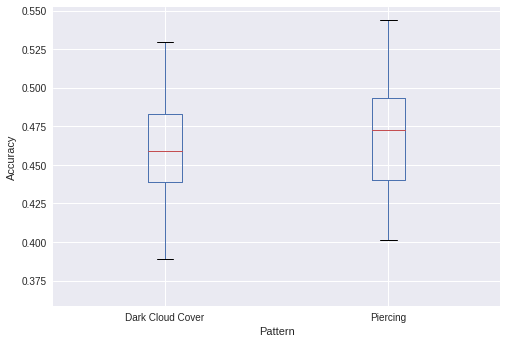

In [188]:
  
DCC = list(acc_p2[acc_p2.Pattern == 'DCC'].acc)
PIER = list(acc_p2[acc_p2.Pattern =='PIER'].acc)

df_plot = pd.DataFrame({
    'Dark Cloud Cover' : DCC,
    'Piercing' : PIER
})
ax = df_plot.plot.box()
ax.set_xlabel('Pattern')
ax.set_ylabel('Accuracy')

### Pattern 3 : Three White soldiers & Three Black Crows

In [0]:
def candle_length(data):
  candles_length = []
  l = data.shape[0]
  for i in range(l):
    day = data.iloc[i]
    candles_length.append(day.close - day.open)
    
  return candles_length

#### Three White Soldiers

In [0]:
def ThreeWhiteSoldiers(data,code,display=False):
  candle = candle_length(data)
  appear = []
  correct = []
  l = data.shape[0]
  # i : index của soldiers ở đỉnh : C
  for i in range(8,l-8): 
    # không cần xét các điểm bên ngoài 
    C = abs(candle[i])
    B = candle[i+1] # 2 ngày trước đó 
    A = candle[i+2]
    # 2 ngày trước phải tăng
    if B > 0 and A > 0:
      if A > B and B > C :
        # check nếu giá 
        # 15 ngày kể từ ngày thứ A ( i+ 2) có >= 8 ngày tăng 
        if(lookbackward(data,i+2,15)[0] >= 8):
          appear.append(i)
          if(lookforward(data,i,15)[1] >= 8):
            correct.append(i)
            if(display):
              plot_pattern(data,'Three White Soldiers of '+ code, 'TWS',i)
  
            
  acc = len(correct)/len(appear) if len(appear) != 0 else 0
  return appear,correct,acc

##### Test

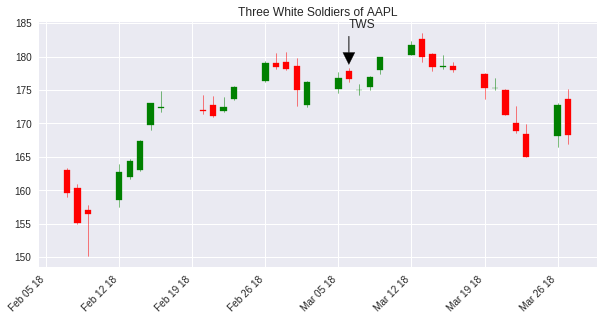

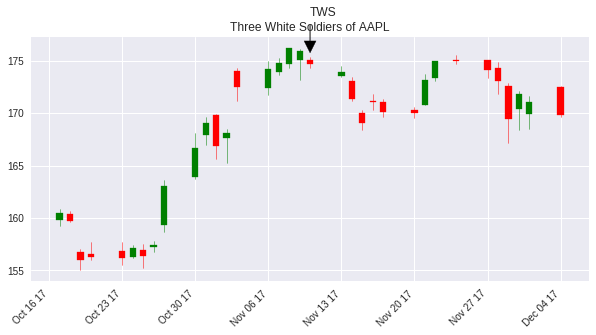

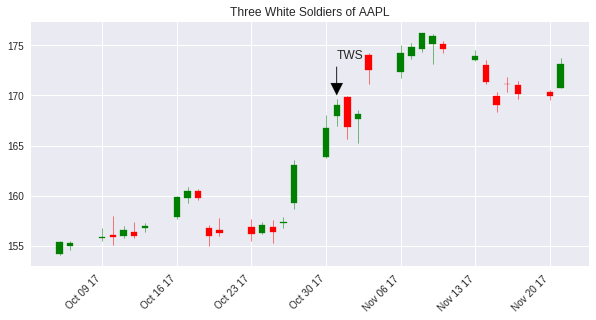

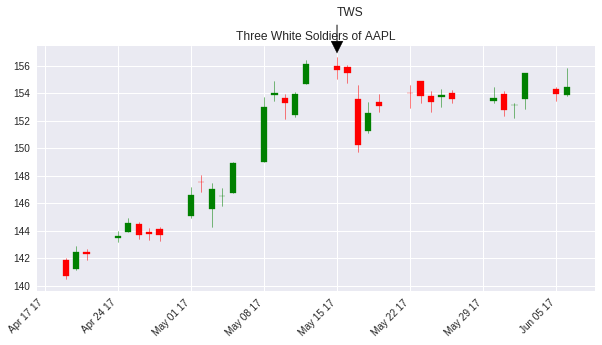

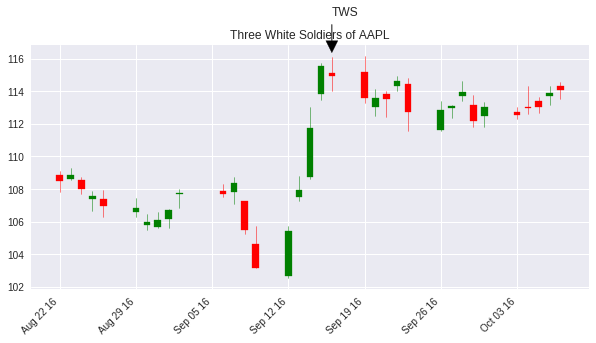

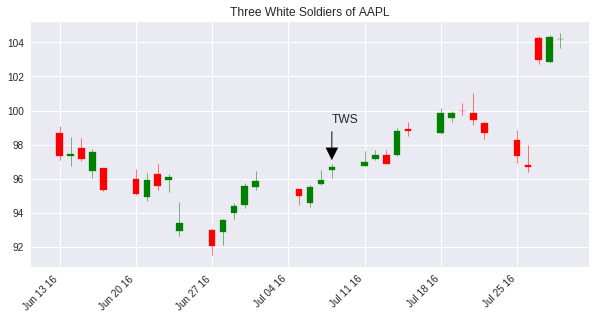

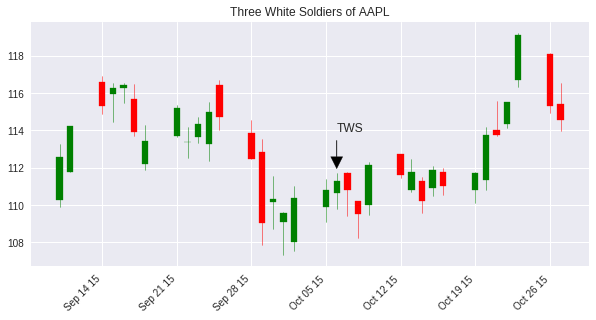

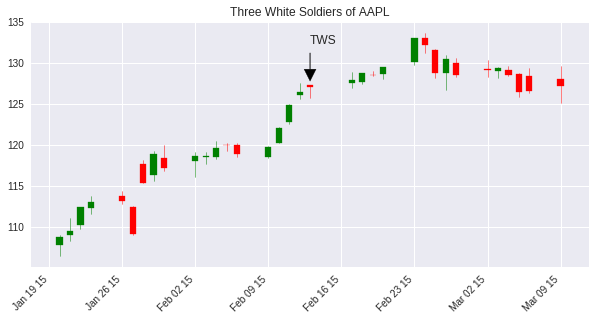

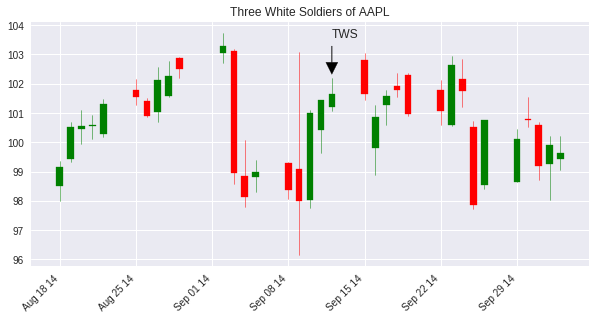

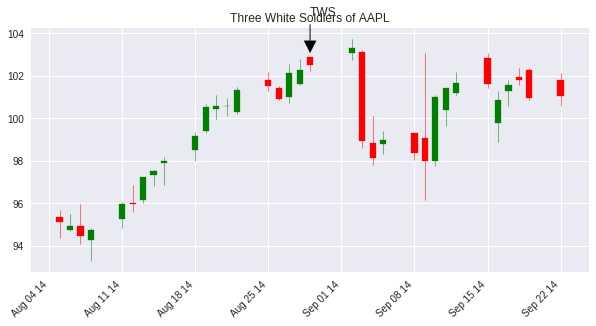

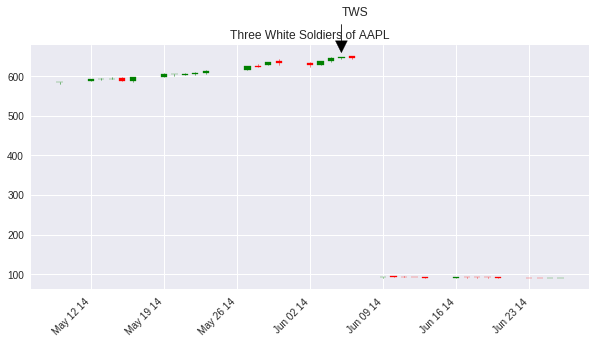

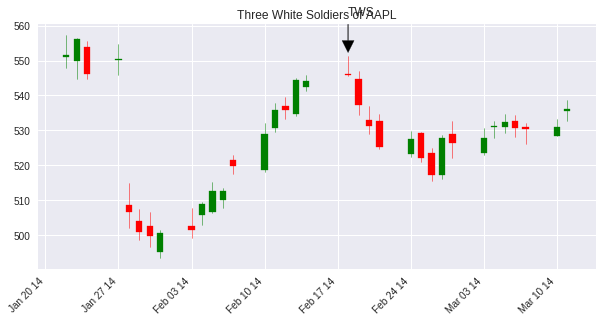

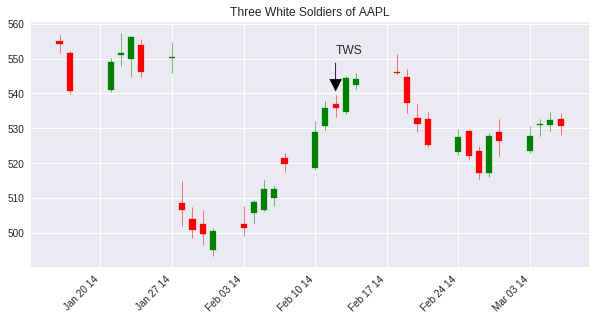

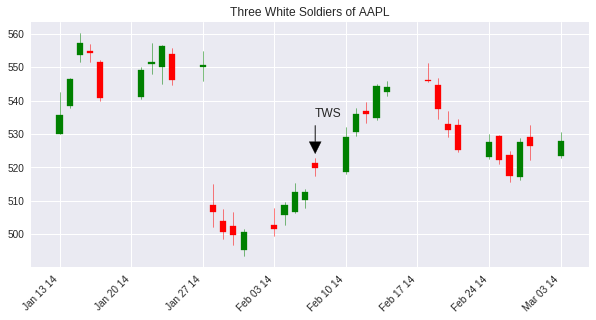

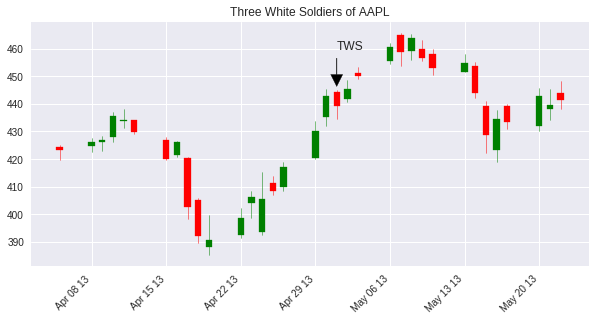

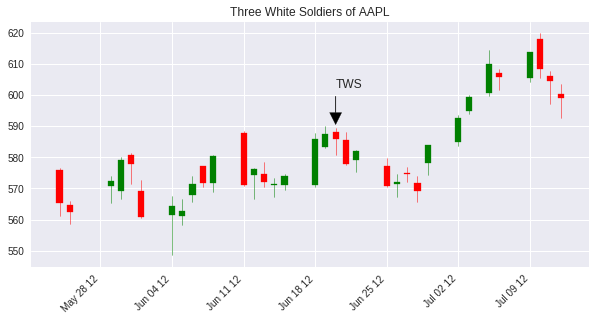

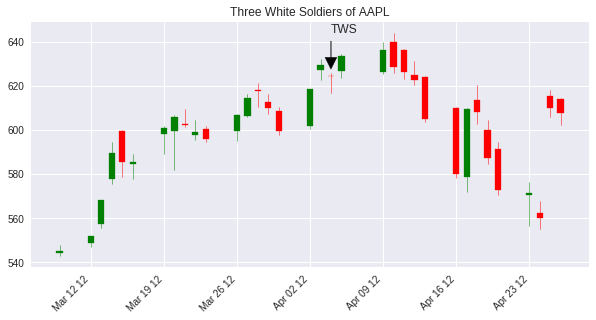

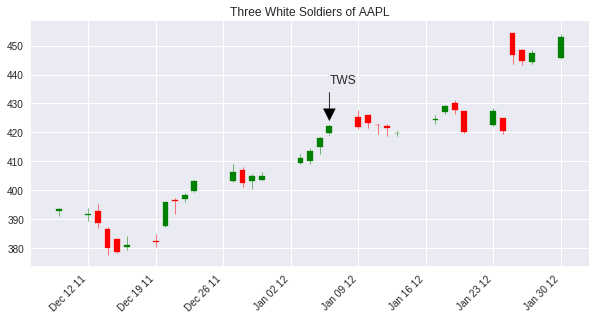

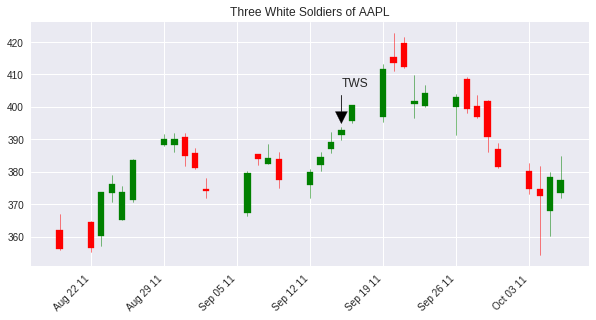

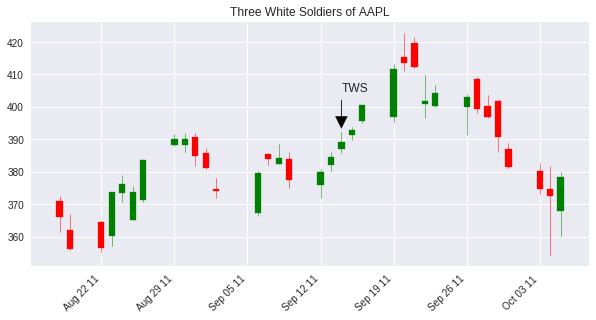

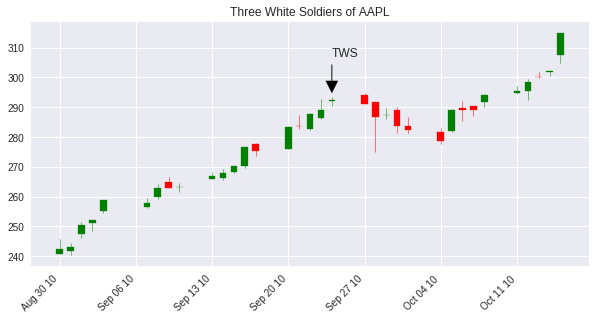

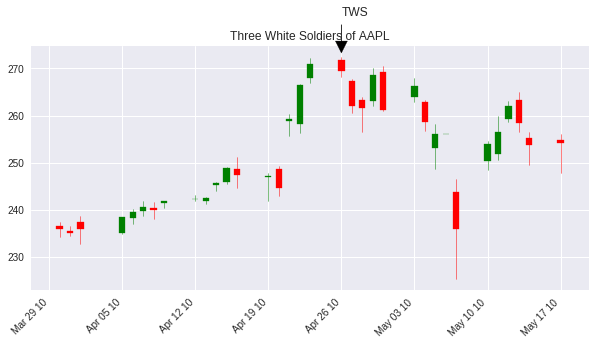

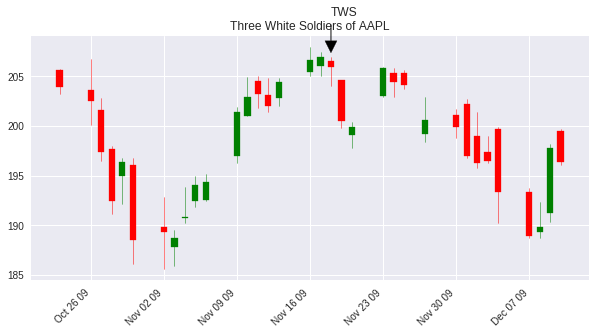

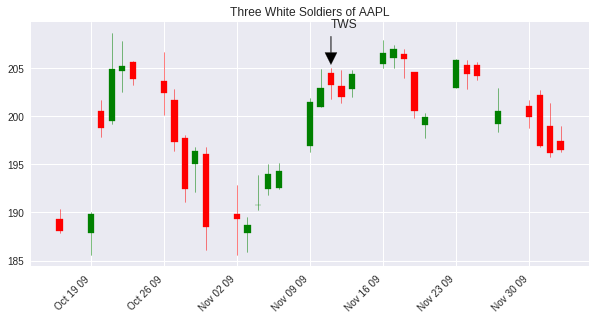

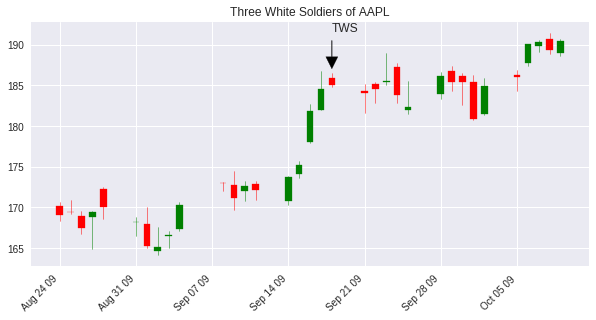

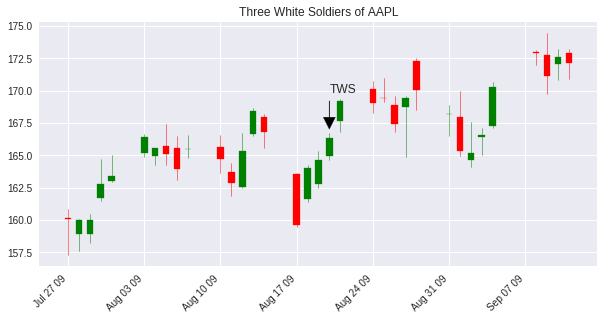

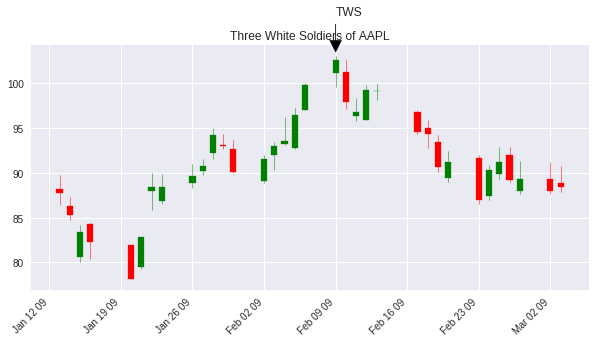

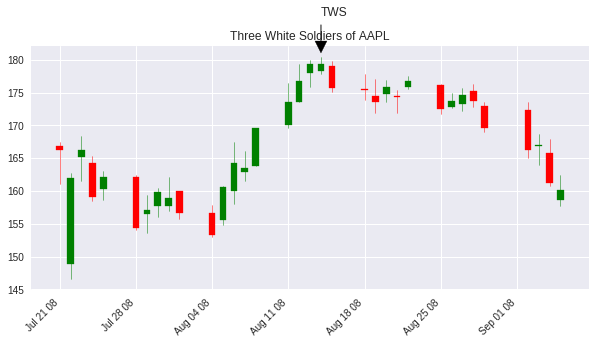

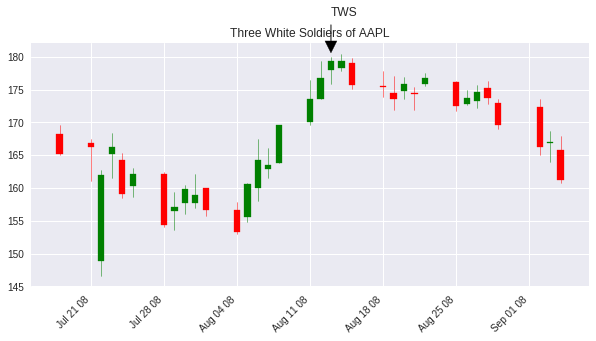

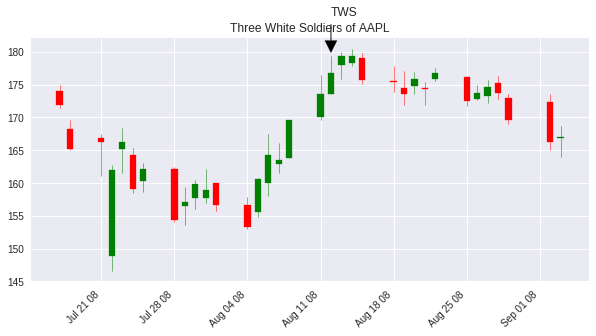

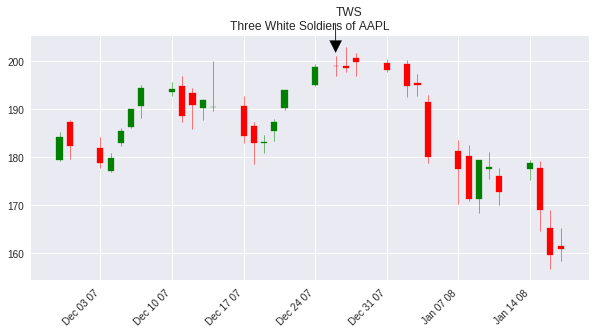

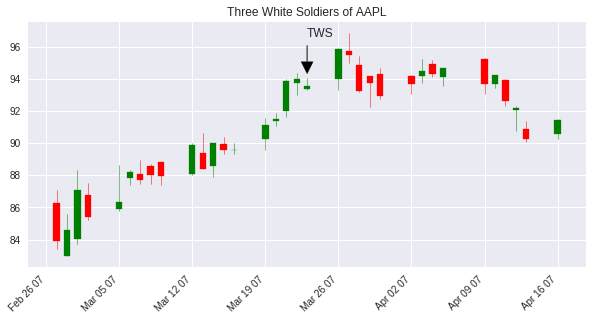

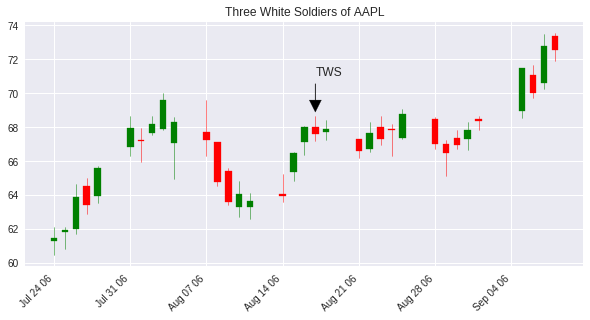

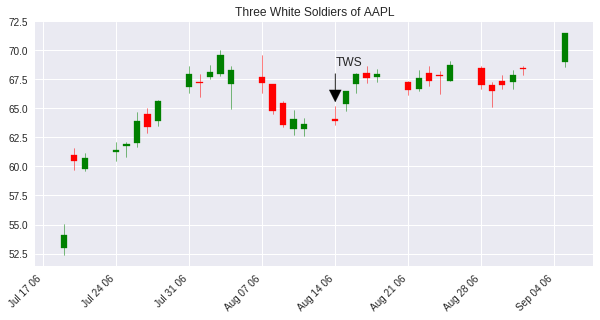

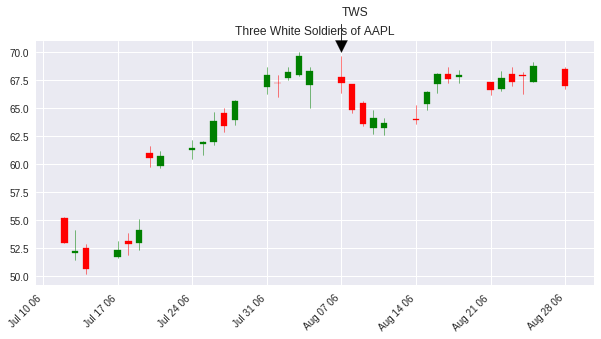

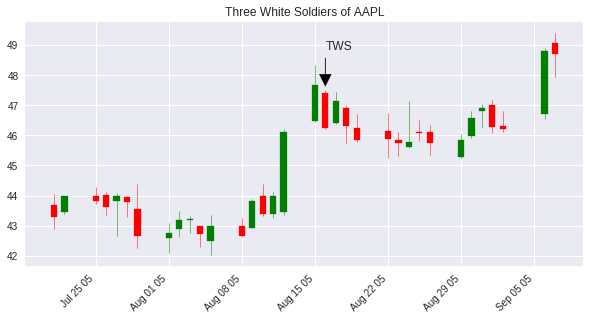

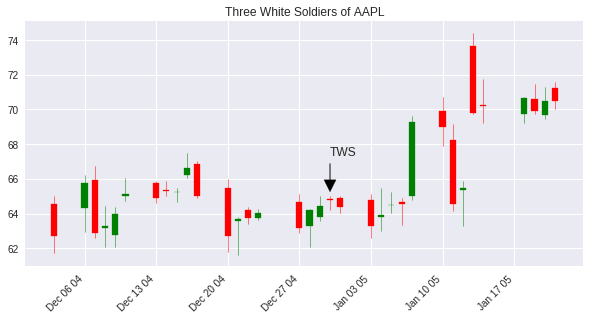

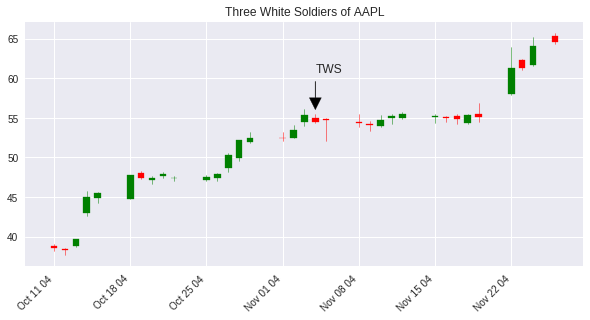

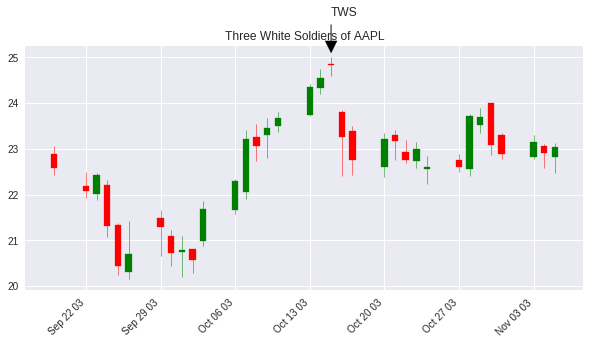

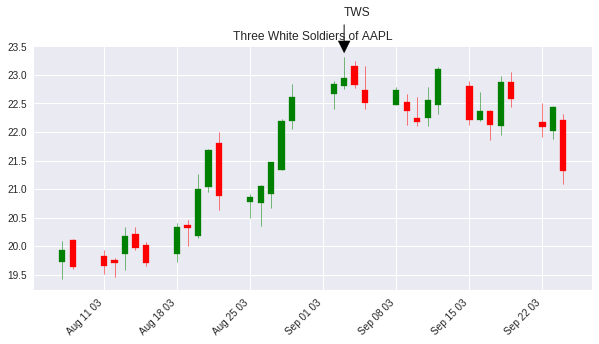

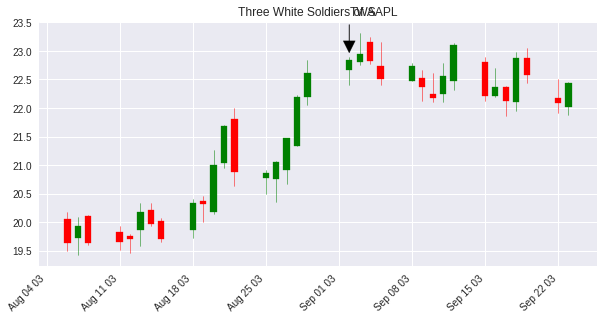

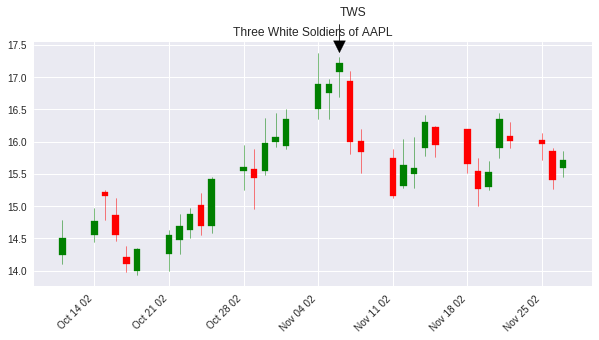

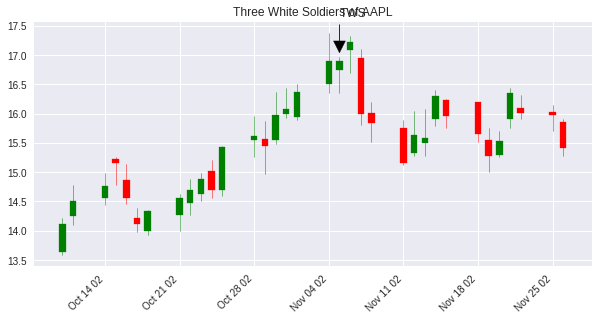

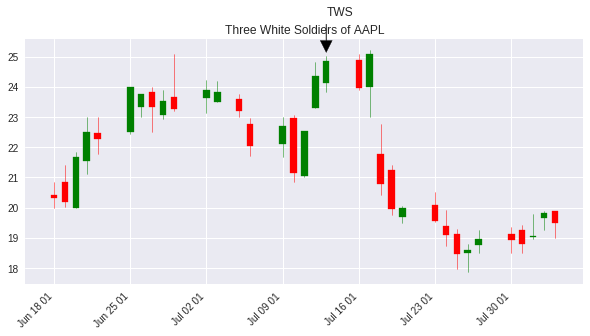

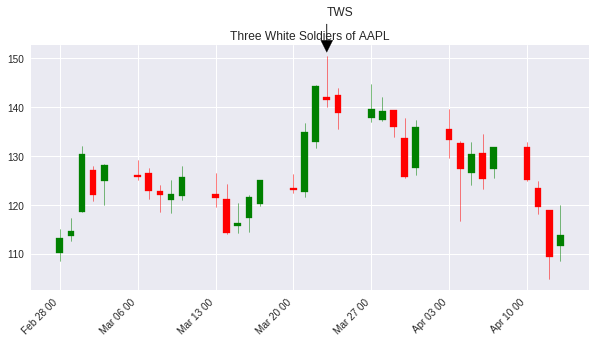

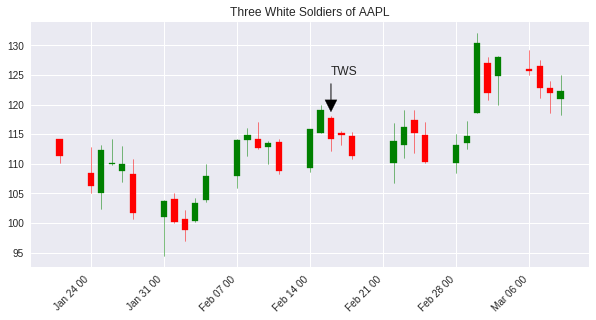

([28,
  75,
  105,
  113,
  122,
  181,
  231,
  297,
  305,
  314,
  317,
  396,
  437,
  445,
  511,
  514,
  531,
  537,
  635,
  797,
  868,
  869,
  903,
  912,
  918,
  972,
  983,
  1047,
  1050,
  1053,
  1185,
  1248,
  1463,
  1516,
  1577,
  1655,
  1656,
  1815,
  1816,
  1901,
  1936,
  2007,
  2029,
  2114,
  2119,
  2157,
  2177,
  2181,
  2191,
  2251,
  2256,
  2263,
  2311,
  2433,
  2434,
  2435,
  2524,
  2536,
  2593,
  2785,
  2874,
  2934,
  2937,
  2942,
  2946,
  3105,
  3110,
  3129,
  3130,
  3187,
  3205,
  3213,
  3345,
  3383,
  3386,
  3486,
  3504,
  3507,
  3508,
  3548,
  3649,
  3679,
  3680,
  3759,
  3760,
  3885,
  3886,
  3901,
  3902,
  3911,
  4130,
  4144,
  4153,
  4157,
  4214,
  4303,
  4543,
  4563,
  4568],
 [28,
  105,
  113,
  231,
  396,
  445,
  635,
  797,
  903,
  912,
  972,
  1047,
  1050,
  1053,
  1248,
  1463,
  1516,
  1577,
  1655,
  1656,
  1901,
  2007,
  2114,
  2119,
  2157,
  2177,
  2311,
  2433,
  2434,
  2435,
  2593,


In [204]:
ThreeWhiteSoldiers(stocks[0],stock_code[0],display=True)

#### Three Black Crows

In [0]:
def ThreeBlackCrows(data,code,display=False):
  candle = candle_length(data)
  appear = []
  correct = []
  l = data.shape[0]
  # i : index của soldiers ở đỉnh : C
  for i in range(8,l-8): 
    # không cần xét các điểm bên ngoài 
    C = abs(candle[i])
    B = candle[i+1] # 2 ngày trước đó 
    A = candle[i+2]
    # 2 ngày trước phải giảm
    if B < 0 and A < 0:
      if abs(A) > abs(B) and abs(B) > abs(C) :
        # 15 ngày kể từ ngày thứ A ( i+ 2) có >= 8 ngày giảm
        if(lookbackward(data,i+2,15)[1] >= 8):
          appear.append(i)
          if(lookforward(data,i,15)[0] >= 8):
            correct.append(i)
            if(display):
              plot_pattern(data,'Three Black Crows of '+ code, 'TBC',i)
              
  acc = len(correct)/len(appear) if len(appear) != 0 else 0  
  return appear,correct,acc

##### Test

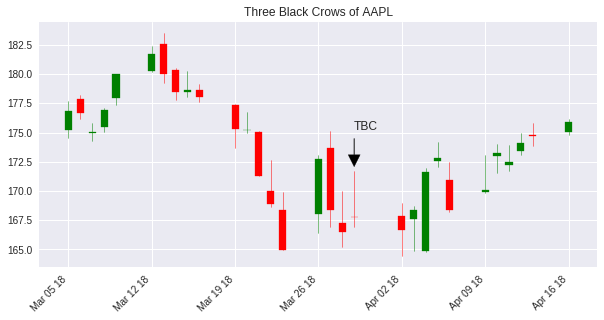

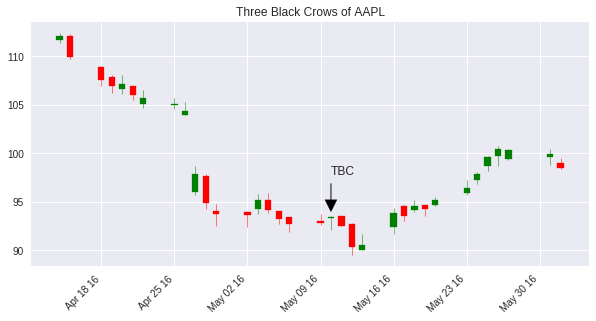

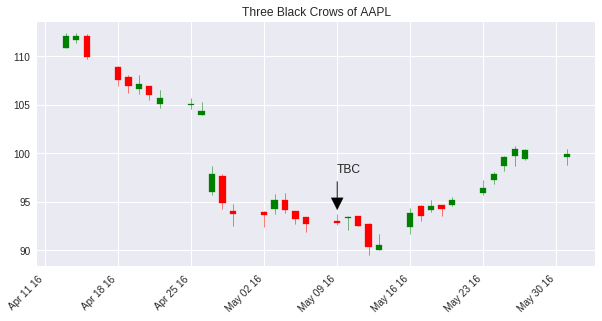

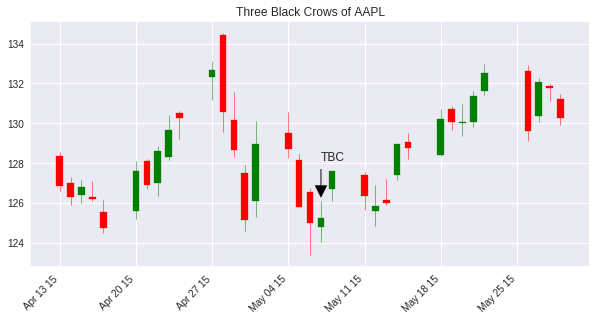

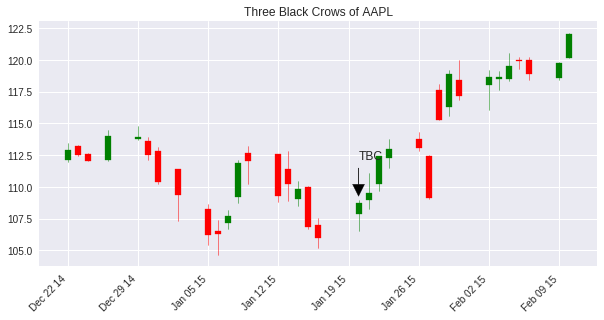

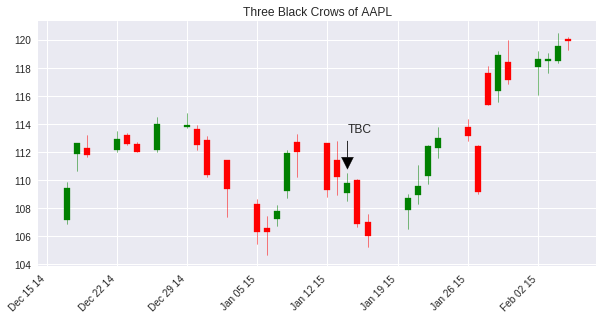

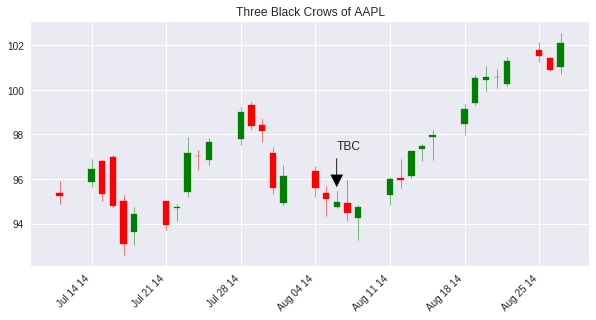

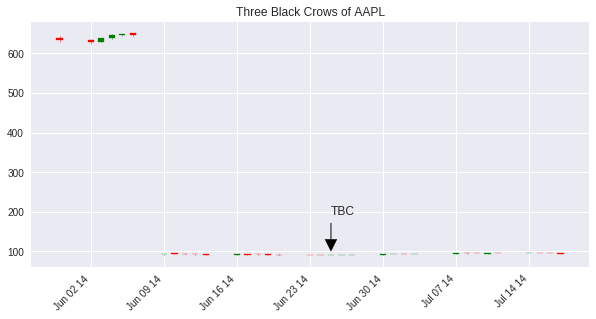

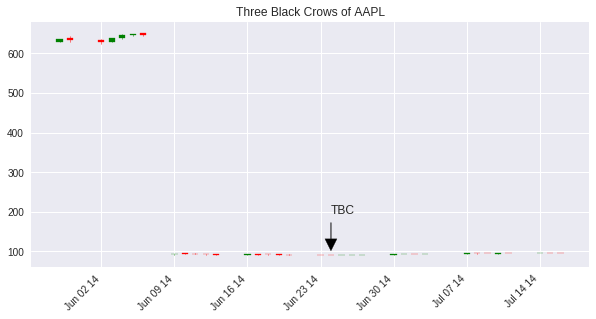

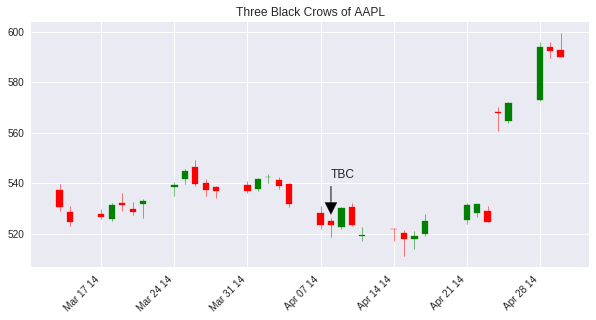

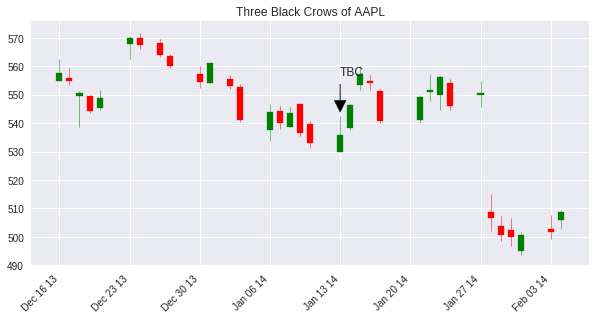

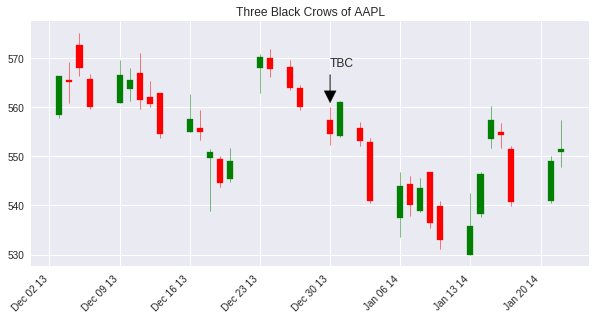

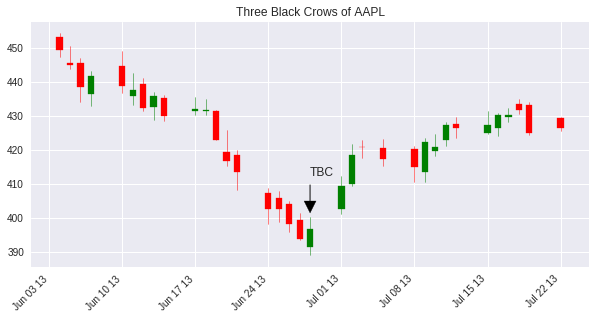

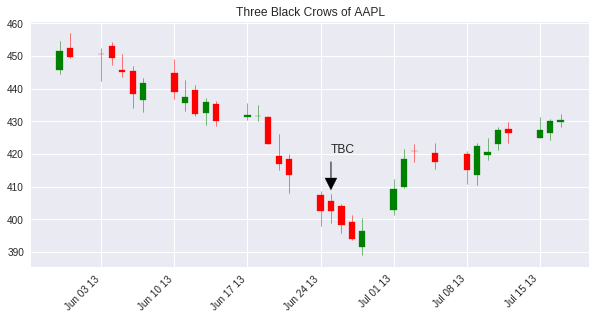

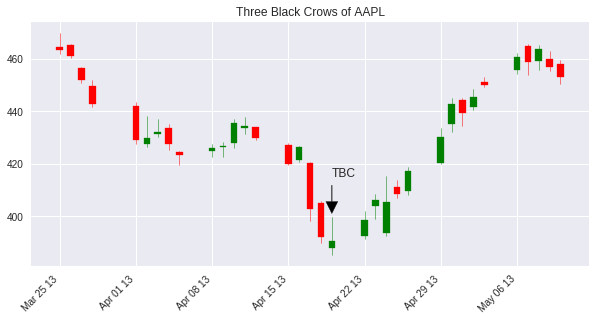

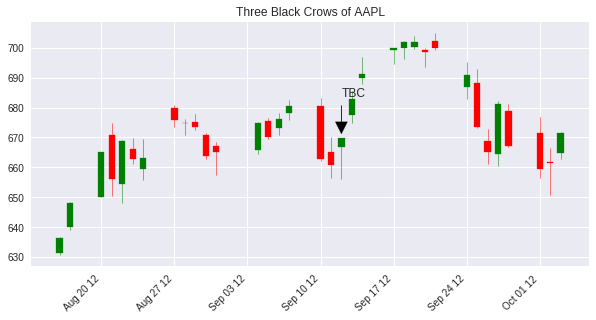

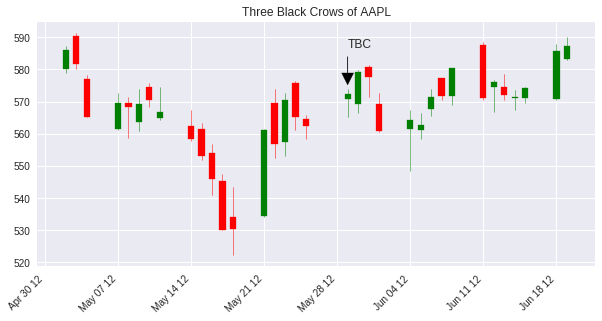

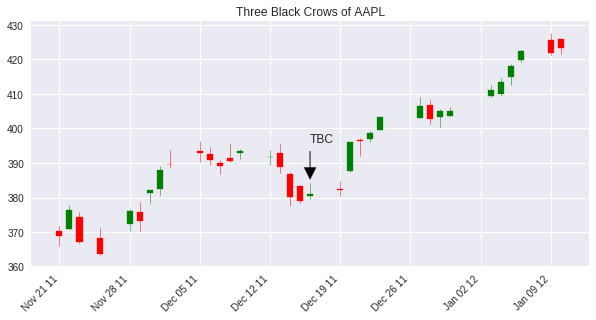

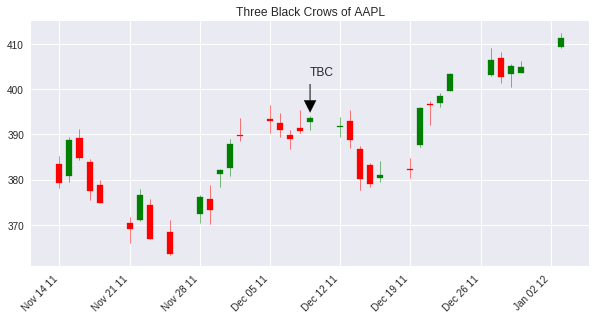

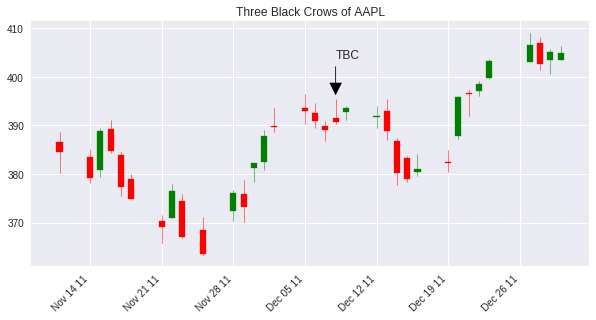

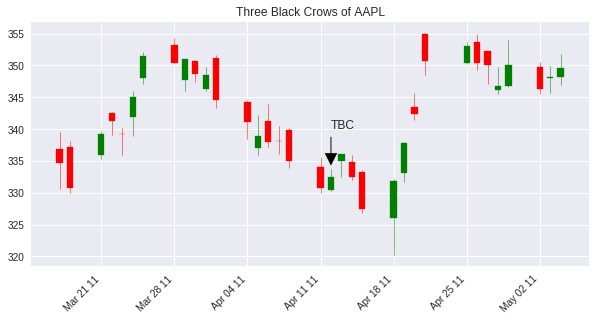

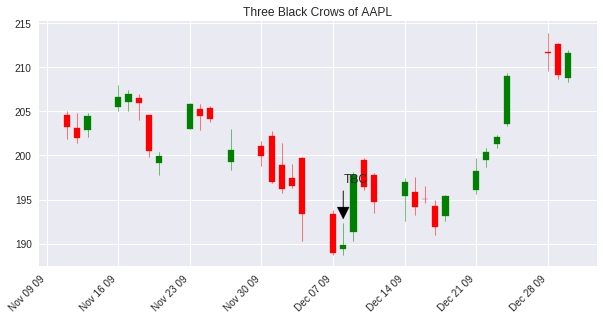

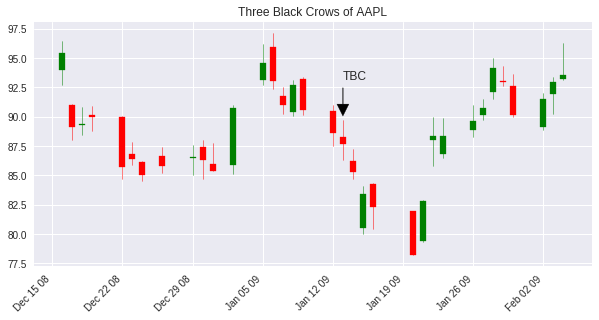

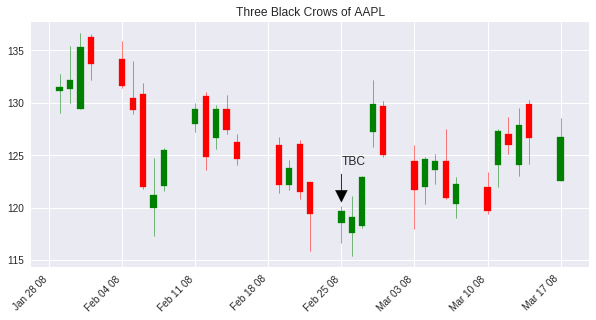

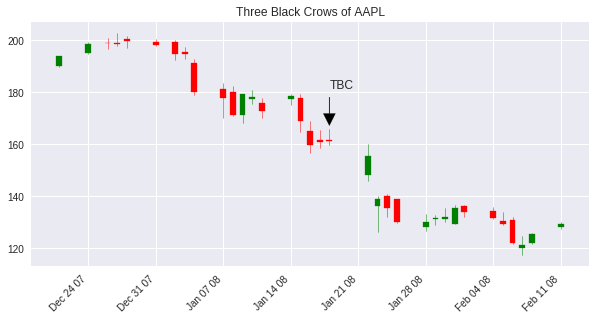

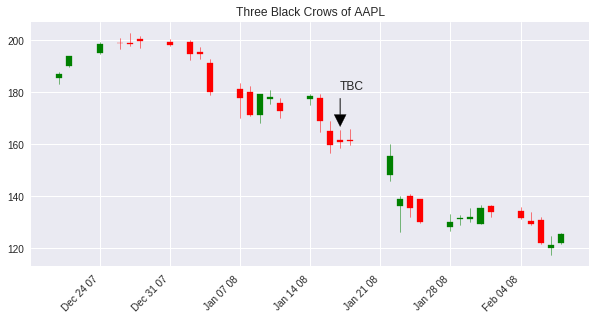

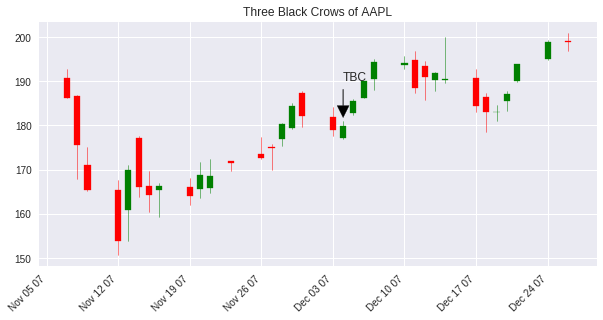

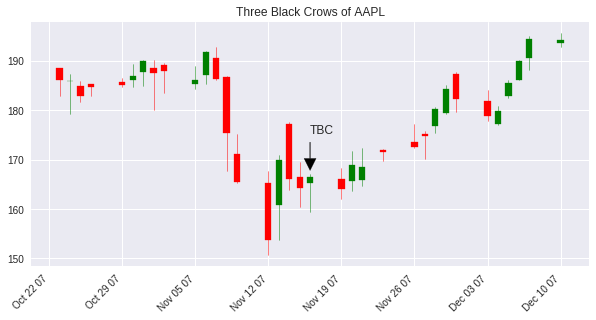

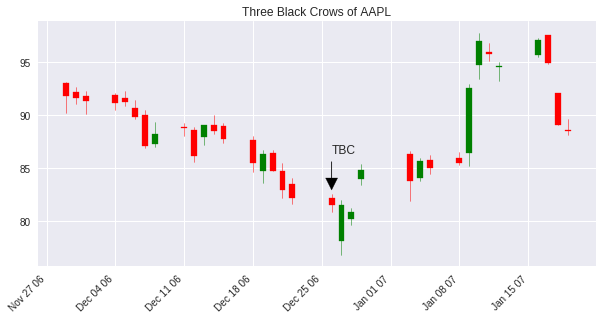

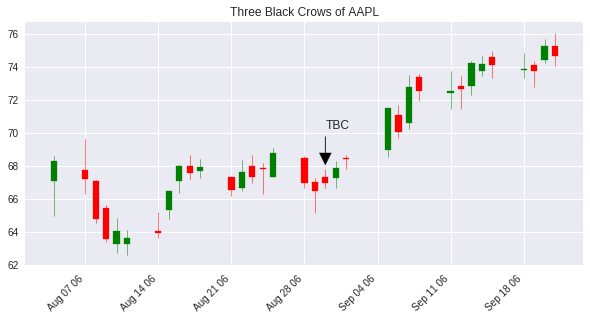

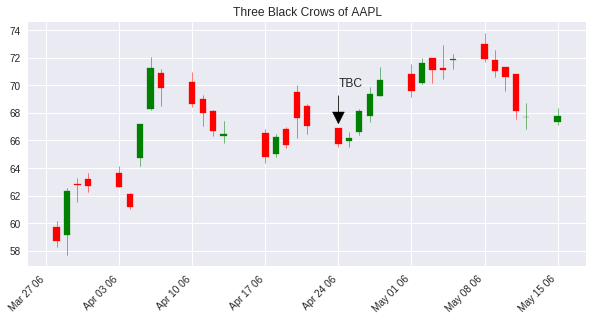

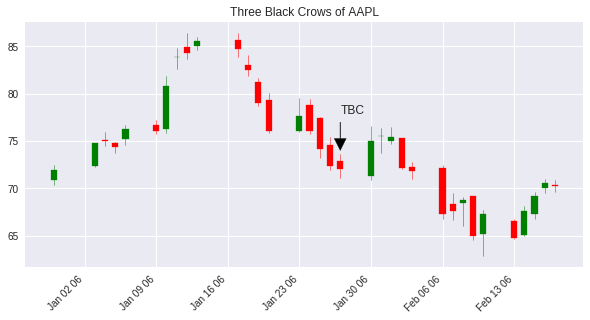

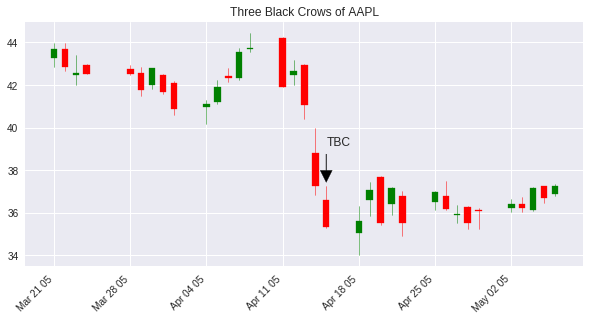

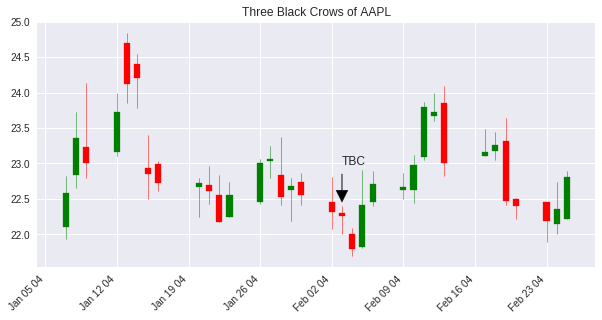

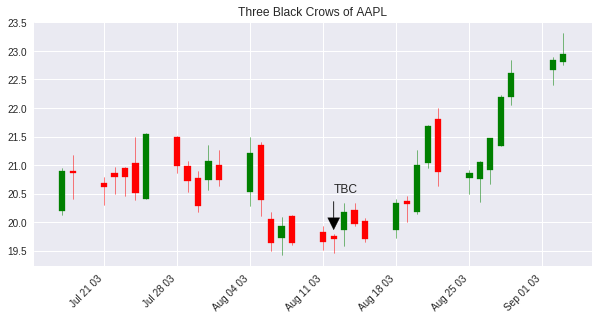

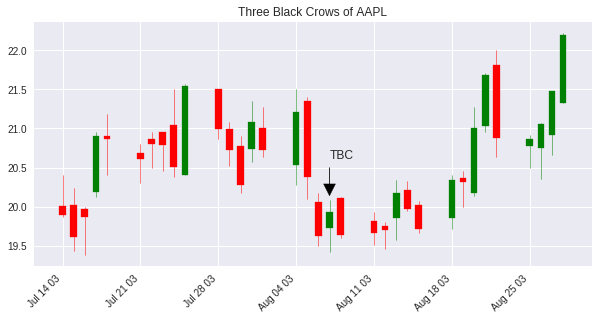

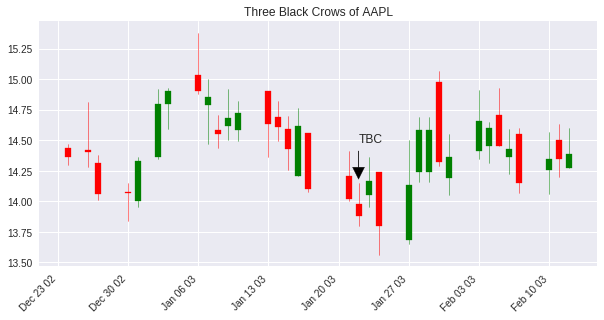

KeyboardInterrupt: ignored

In [206]:
ThreeBlackCrows(stocks[0],stock_code[0],display=True)

#### Compare performance

In [0]:
result = []
for i in range(len(stocks)):
  a,c,acc = ThreeBlackCrows(stocks[i],stock_code[i],display=False)
  result.append({'Pattern':'TBC','code': stock_code[i],'appear':len(a),'correct':len(c),'acc' : acc})
  a,c,acc = ThreeWhiteSoldiers(stocks[i],stock_code[i],display=False)
  result.append({'Pattern':'TWS','code': stock_code[i],'appear':len(a),'correct':len(c),'acc' : acc})

In [0]:
acc_p3 = pd.DataFrame(result)
acc_p3 = acc_p2[['code','Pattern','appear','correct','acc']]

In [0]:
df_plot = pd.DataFrame({
    'TBC' : list(acc_p3[acc_p3.Pattern == 'TBC'].acc),
    'TWS' : list(acc_p3[acc_p3.Pattern == 'TWS'].acc),
})

Text(0,0.5,'Accuracy')

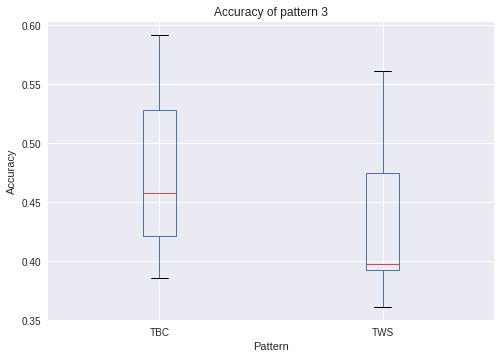

In [220]:
ax = df_plot.plot.box()
ax.set_title('Accuracy of pattern 3')
ax.set_xlabel('Pattern')
ax.set_ylabel('Accuracy')

In [0]:
acc_p3.to_csv('P3.csv')
files.download('P3.csv')

## All performance

In [221]:
!ls

AAPL.csv  BAC.csv   datalab    INTC.csv  JPM.csv   P1.csv  WMT.csv
AMZN.csv  CSCO.csv  GOOGL.csv  JNJ.csv	 MSFT.csv  P2.csv


In [0]:
df1 = pd.read_csv('P1.csv')
df2 = pd.read_csv('P2.csv')
df3 = pd.read_csv('P3.csv')

In [0]:
df_plot = pd.DataFrame({
    'WHammer': list(df1[df1.Pattern == 'WH'].acc),
    'BHammer' : list(df1[df1.Pattern =='BH'].acc),
    'BShooting' : list(df1[df1.Pattern == 'BSS'].acc),
    'WShooting' : list(df1[df1.Pattern == 'WSS'].acc),
    'Dark CC' : list(df2[df2.Pattern == 'DCC'].acc),
    'Piercing' : list(df2[df2.Pattern =='PIER'].acc),
})

Text(0,0.5,'Accuracy')

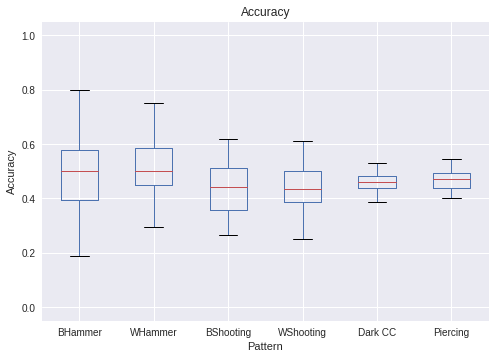

In [232]:
ax = df_plot[['BHammer','WHammer','BShooting','WShooting','Dark CC','Piercing']].plot.box()
ax.set_title('Accuracy')
ax.set_xlabel('Pattern')
ax.set_ylabel('Accuracy')

Text(0,0.5,'Accuracy')

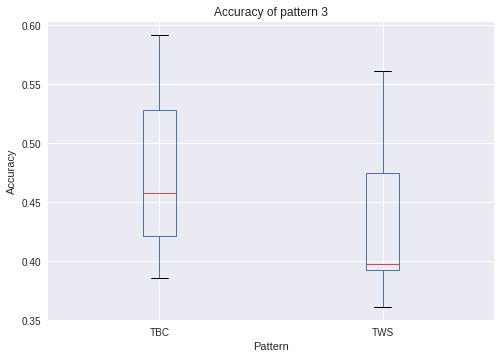

In [233]:
df_plot = pd.DataFrame({
    'TBC' : list(acc_p3[acc_p3.Pattern == 'TBC'].acc),
    'TWS' : list(acc_p3[acc_p3.Pattern == 'TWS'].acc),
})

ax = df_plot.plot.box()
ax.set_title('Accuracy of pattern 3')
ax.set_xlabel('Pattern')
ax.set_ylabel('Accuracy')